In [ ]:
# ============================================
# ИНСТРУКЦИЯ ПО ЗАПУСКУ
# ============================================
# 1. Запустите эту ячейку (установка библиотек)
# 2. ПРОПУСТИТЕ ячейку 1 (она отключена)
# 3. Запустите ячейку 2 - там весь функционал бота
# 4. Бот запустится и будет работать 1 час
# ============================================

%pip install python-telegram-bot==20.3

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [ ]:
# ЭТА ЯЧЕЙКА ОТКЛЮЧЕНА - ВСЁ В ЯЧЕЙКЕ 2
# Для работы в Colab нужно разрешить вложенные event loops
# import nest_asyncio
# nest_asyncio.apply()

# from telegram import Update
# from telegram.ext import ApplicationBuilder, CommandHandler, ContextTypes

# BOT_TOKEN = "8384555727:AAEZ-Z6M0QIrsXpJkBr69fOPTs5bgvJnydY"

# async def start(update: Update, context: ContextTypes.DEFAULT_TYPE):
#     await update.message.reply_text("👋 Привет! Я — StockSensebot. Бот успешно запущен!")

# # Создаём и настраиваем приложение
# app = ApplicationBuilder().token(BOT_TOKEN).build()
# app.add_handler(CommandHandler("start", start))

# print("🚀 Инициализация бота...")
# print("✅ Бот запущен. Можешь писать /start своему боту в Telegram.")

# # Запускаем бота (для Colab используем run_polling напрямую)
# app.run_polling()

print("⚠️ Эта ячейка отключена. Запустите ячейку 2 для работы бота.")

🚀 Инициализация бота...
✅ Бот запущен. Можешь писать /start своему боту в Telegram.


Error while getting Updates: Conflict: terminated by other getUpdates request; make sure that only one bot instance is running
No error handlers are registered, logging exception.
Traceback (most recent call last):
  File "/Users/ivanfrolovich/Library/Python/3.9/lib/python/site-packages/telegram/ext/_updater.py", line 607, in _network_loop_retry
    if not await action_cb():
  File "/Users/ivanfrolovich/Library/Python/3.9/lib/python/site-packages/telegram/ext/_updater.py", line 335, in polling_action_cb
    raise exc
  File "/Users/ivanfrolovich/Library/Python/3.9/lib/python/site-packages/telegram/ext/_updater.py", line 320, in polling_action_cb
    updates = await self.bot.get_updates(
  File "/Users/ivanfrolovich/Library/Python/3.9/lib/python/site-packages/telegram/ext/_extbot.py", line 543, in get_updates
    updates = await super().get_updates(
  File "/Users/ivanfrolovich/Library/Python/3.9/lib/python/site-packages/telegram/_bot.py", line 381, in decorator
    result = await func(

RuntimeError: Cannot close a running event loop

In [ ]:
%pip install python-telegram-bot==20.3 yfinance scikit-learn statsmodels tensorflow matplotlib pandas numpy nest-asyncio -q

# Для работы в Colab
import nest_asyncio
nest_asyncio.apply()

import os
import asyncio
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from telegram import Update, InlineKeyboardMarkup, InlineKeyboardButton
from telegram.ext import (
    ApplicationBuilder,
    CommandHandler,
    CallbackQueryHandler,
    MessageHandler,
    ConversationHandler,
    ContextTypes,
    filters
)
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import warnings
warnings.filterwarnings("ignore")

BOT_TOKEN = "8384555727:AAEZ-Z6M0QIrsXpJkBr69fOPTs5bgvJnydY"

# Создаём папки
os.makedirs("plots", exist_ok=True)

# Состояния для ConversationHandler
WAITING_INVESTMENT = range(1)

# --- Главное меню ---
async def main_menu(update: Update, context: ContextTypes.DEFAULT_TYPE, edit=False):
    keyboard = [
        [
            InlineKeyboardButton("📈 Акции", callback_data="stocks"),
            InlineKeyboardButton("₿ Крипта", callback_data="crypto"),
            InlineKeyboardButton("💱 Форекс", callback_data="forex")
        ],
        [InlineKeyboardButton("ℹ️ Помощь", callback_data="help")]
    ]
    markup = InlineKeyboardMarkup(keyboard)

    text = (
        "👋 Привет! Я — *StockSenseAIbot* 🤖\n\n"
        "Я анализирую финансовые данные и строю прогнозы с помощью AI-моделей.\n"
        "Выбери категорию ниже 👇"
    )

    if edit:
        await update.callback_query.edit_message_text(
            text=text, reply_markup=markup, parse_mode="Markdown"
        )
    else:
        await update.message.reply_text(
            text=text, reply_markup=markup, parse_mode="Markdown"
        )


# --- Обработка команды /start ---
async def start(update: Update, context: ContextTypes.DEFAULT_TYPE):
    await main_menu(update, context, edit=False)


# --- Обработка кнопок ---
async def button(update: Update, context: ContextTypes.DEFAULT_TYPE):
    query = update.callback_query
    await query.answer()
    data = query.data

    # Меню акций
    if data == "stocks":
        tickers = [
            ["AAPL", "MSFT", "GOOGL"],
            ["AMZN", "META", "NVDA"],
            ["TSLA", "NFLX", "DIS"],
            ["🏠 Главное меню"]
        ]
        keyboard = [[InlineKeyboardButton(t, callback_data=t) for t in row] for row in tickers]
        await query.edit_message_text(
            text="📊 Выберите акцию:",
            reply_markup=InlineKeyboardMarkup(keyboard)
        )

    elif data == "help":
        help_text = (
            "📘 *Полезные команды:*\n"
            "/start — главное меню\n"
            "/predict — прогноз по тикеру\n\n"
            "📈 *Акции:* /stocks\n"
            "₿ *Крипта:* /crypto\n"
            "💱 *Форекс:* /forex\n\n"
            "⚠️ Все данные носят исключительно учебный характер."
        )
        keyboard = [[InlineKeyboardButton("🏠 Главное меню", callback_data="menu")]]
        await query.edit_message_text(
            text=help_text, reply_markup=InlineKeyboardMarkup(keyboard), parse_mode="Markdown"
        )

    elif data == "menu" or data == "🏠 Главное меню":
        # Возвращаем в главное меню
        await main_menu(update, context, edit=True)

    # Тикеры обрабатываются через button_handler в ConversationHandler
    # Здесь не обрабатываем, чтобы не конфликтовать

    elif data in ["crypto", "forex"]:
        keyboard = [[InlineKeyboardButton("🏠 Главное меню", callback_data="menu")]]
        await query.edit_message_text(
            "🚧 Эта функция пока в разработке.\nСкоро здесь будет анализ криптовалют и валютных пар!",
            reply_markup=InlineKeyboardMarkup(keyboard)
        )

    else:
        await query.message.reply_text("Эта функция пока в разработке 🙂")


# ============================================
# ФУНКЦИЯ ЛОГИРОВАНИЯ
# ============================================

def log_request(user_id: int, ticker: str, investment: float, best_model: str,
                rmse: float, mape: float, buy_date, buy_price: float,
                sell_date, sell_price: float, profit: float):
    """Записывает запрос в logs.txt"""
    log_entry = (
        f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}, "
        f"user_id={user_id}, "
        f"ticker={ticker}, "
        f"investment={investment:.2f}, "
        f"best_model={best_model}, "
        f"RMSE={rmse:.4f}, "
        f"MAPE={mape:.4f}, "
        f"buy_date={buy_date}, buy_price={buy_price:.2f}, "
        f"sell_date={sell_date}, sell_price={sell_price:.2f}, "
        f"profit={profit:.2f}\n"
    )
    with open("logs.txt", "a", encoding="utf-8") as f:
        f.write(log_entry)
    return log_entry

# ============================================
# ФУНКЦИЯ АНАЛИЗА (рабочая версия)
# ============================================

def run_stock_analysis(ticker: str, investment: float):
    """Полный цикл анализа акций"""
    # 1. ЗАГРУЗКА ДАННЫХ
    data = yf.download(ticker, period="2y", interval="1d", auto_adjust=True, progress=False)

    if data.empty or "Close" not in data.columns:
        raise ValueError(f"Не удалось загрузить данные по тикеру {ticker}")

    s = data["Close"].dropna()
    s.name = ticker

    # Разделение на train/test
    split_idx = int(len(s) * 0.8)
    train = s.iloc[:split_idx]
    test = s.iloc[split_idx:]

    results = {}

    # 2. RIDGE REGRESSION
    def create_lag_features(series, lag=5):
        df = pd.DataFrame({"Close": series})
        for i in range(1, lag + 1):
            df[f"lag_{i}"] = df["Close"].shift(i)
        df.dropna(inplace=True)
        return df

    def evaluate(y_true, y_pred):
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        mape = mean_absolute_percentage_error(y_true, y_pred)
        return rmse, mape

    ridge_data = create_lag_features(s, lag=5)
    X = ridge_data.drop("Close", axis=1)
    y = ridge_data["Close"]

    X_train, X_test = X[:-30], X[-30:]
    y_train, y_test = y[:-30], y[-30:]

    ridge = Ridge()
    ridge.fit(X_train, y_train)
    ridge_pred = ridge.predict(X_test)
    rmse, mape = evaluate(y_test, ridge_pred)
    results["Ridge Regression"] = (rmse, mape, ridge_pred, y_test.index)

    # 3. ARIMA
    try:
        model_arima = ARIMA(train, order=(2,1,2))
        arima_fit = model_arima.fit()
        arima_pred = arima_fit.forecast(steps=len(test))
        rmse, mape = evaluate(test, arima_pred)
        results["ARIMA"] = (rmse, mape, arima_pred, test.index)
    except:
        arima_pred = np.full(len(test), train.iloc[-1])
        rmse, mape = evaluate(test, arima_pred)
        results["ARIMA"] = (rmse, mape, arima_pred, test.index)

    # 4. LSTM
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
    test_scaled = scaler.transform(test.values.reshape(-1, 1))

    def create_sequences(data_scaled, window=20):
        X_seq, y_seq = [], []
        for i in range(window, len(data_scaled)):
            X_seq.append(data_scaled[i-window:i, 0])
            y_seq.append(data_scaled[i, 0])
        return np.array(X_seq), np.array(y_seq)

    window = 20
    X_train_lstm, y_train_lstm = create_sequences(train_scaled, window)
    X_test_lstm, y_test_lstm = create_sequences(
        np.concatenate([train_scaled[-window:], test_scaled]), window
    )

    X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
    X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

    model_lstm = Sequential()
    model_lstm.add(LSTM(50, return_sequences=False, input_shape=(X_train_lstm.shape[1], 1)))
    model_lstm.add(Dense(1))
    model_lstm.compile(optimizer="adam", loss="mse")

    model_lstm.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=16, verbose=0)

    lstm_pred_scaled = model_lstm.predict(X_test_lstm, verbose=0)
    lstm_pred = scaler.inverse_transform(lstm_pred_scaled).flatten()

    test_lstm = test[-len(lstm_pred):]
    rmse, mape = evaluate(test_lstm.values, lstm_pred)
    results["LSTM"] = (rmse, mape, lstm_pred, test_lstm.index)

    # 5. ВЫБОР ЛУЧШЕЙ МОДЕЛИ
    results_df = pd.DataFrame({k: {"RMSE": v[0], "MAPE": v[1]} for k, v in results.items()}).T
    best_model = results_df["RMSE"].idxmin()

    # 6. СТРОИМ ПРОГНОЗ НА 30 ДНЕЙ ВПЕРЁД (не только на тестовые данные!)
    # Текущая цена - последняя цена в данных
    current_price = float(s.iloc[-1])
    last_date = s.index[-1]

    # Создаём даты для прогноза на 30 дней вперёд
    from pandas.tseries.offsets import BDay
    forecast_dates = pd.date_range(start=last_date + BDay(1), periods=30, freq='B')

    # Строим прогноз на 30 дней вперёд в зависимости от лучшей модели
    if best_model == "Ridge Regression":
        # Для Ridge нужно переобучить на всех данных и прогнозировать вперёд
        # Используем все данные для обучения финальной модели
        ridge_full_data = create_lag_features(s, lag=5)
        X_full = ridge_full_data.drop("Close", axis=1)
        y_full = ridge_full_data["Close"]

        # Обучаем на всех данных
        ridge_full = Ridge()
        ridge_full.fit(X_full, y_full)

        # Берём последние 5 значений для прогноза
        last_5_values = s.iloc[-5:].values
        forecast_30 = []

        # Прогнозируем пошагово на 30 дней
        for i in range(30):
            # Создаём лаговые признаки из последних значений
            X_pred = np.array([last_5_values[-5:]]).reshape(1, -1)
            pred = ridge_full.predict(X_pred)[0]
            forecast_30.append(pred)
            # Обновляем последние значения (сдвигаем и добавляем новый прогноз)
            last_5_values = np.append(last_5_values[1:], pred)

        forecast_series = pd.Series(forecast_30, index=forecast_dates)

    elif best_model == "ARIMA":
        # ARIMA может прогнозировать вперёд
        try:
            model_arima_full = ARIMA(s, order=(2,1,2))
            arima_fit_full = model_arima_full.fit()
            forecast_30 = arima_fit_full.forecast(steps=30)
            forecast_series = pd.Series(forecast_30, index=forecast_dates)
        except:
            # Если не получается, используем последнюю цену
            forecast_30 = np.full(30, current_price)
            forecast_series = pd.Series(forecast_30, index=forecast_dates)
    else:  # LSTM
        # Для LSTM нужно использовать последние данные для прогноза
        last_window = s.iloc[-window:].values
        last_window_scaled = scaler.transform(last_window.reshape(-1, 1))

        # Прогнозируем пошагово на 30 дней
        forecast_30_scaled = []
        input_seq = last_window_scaled.reshape(1, window, 1)

        for _ in range(30):
            pred = model_lstm.predict(input_seq, verbose=0)
            forecast_30_scaled.append(pred[0, 0])
            # Обновляем последовательность
            input_seq = np.append(input_seq[:, 1:, :], pred.reshape(1, 1, 1), axis=1)

        forecast_30 = scaler.inverse_transform(np.array(forecast_30_scaled).reshape(-1, 1)).flatten()
        forecast_series = pd.Series(forecast_30, index=forecast_dates)

    # Изменение цены относительно текущей
    change = (forecast_series.iloc[-1] - current_price) / current_price * 100
    direction = "📈 вырастет" if change > 0 else "📉 снизится"

    # 7. СТРАТЕГИЯ И ПРИБЫЛЬ (на прогнозе на 30 дней)
    min_day = forecast_series.idxmin()
    max_day = forecast_series.idxmax()
    buy_price = float(forecast_series.min())
    sell_price = float(forecast_series.max())

    profit = (sell_price - buy_price) / buy_price * investment

    # 8. ГРАФИКИ
    # График 1 — прогноз на 30 дней вперёд
    plt.figure(figsize=(12, 5))
    # История (все данные до текущего момента)
    plt.plot(s.index, s.values, label="История", linewidth=1.5, alpha=0.7, color="gray")

    # Текущая цена (последняя точка)
    plt.scatter(last_date, current_price, color="blue", marker="o", s=100, label="Текущая цена", zorder=5)

    # Прогноз на 30 дней вперёд
    above_mask = forecast_series >= current_price
    below_mask = forecast_series < current_price

    plt.scatter(
        forecast_series.index[above_mask],
        forecast_series[above_mask],
        label="Прогноз (выше текущей цены)",
        color="green",
        marker="o",
        s=55,
        edgecolor="black",
        linewidth=0.6,
        alpha=0.9
    )
    plt.scatter(
        forecast_series.index[below_mask],
        forecast_series[below_mask],
        label="Прогноз (ниже текущей цены)",
        color="red",
        marker="o",
        s=55,
        edgecolor="black",
        linewidth=0.6,
        alpha=0.9
    )
    plt.plot(forecast_series.index, forecast_series.values, linestyle=":", linewidth=2, alpha=0.8, color="blue", label="Прогноз (30 дней)")

    plt.title(f"{ticker} — прогноз на 30 дней ({best_model})", fontsize=14)
    plt.xlabel("Дата")
    plt.ylabel("Цена, $")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plot_main_path = f"plots/{ticker}_forecast.png"
    plt.savefig(plot_main_path, dpi=150)
    plt.close()

    # График 2 — стратегия покупки/продажи
    plt.figure(figsize=(12, 5))
    # История
    plt.plot(s.index, s.values, label="История", linewidth=1.5, alpha=0.7, color="gray")
    # Текущая цена
    plt.scatter(last_date, current_price, color="blue", marker="o", s=100, label="Текущая цена", zorder=5)
    # Прогноз
    plt.plot(forecast_series.index, forecast_series.values, label="Прогноз (30 дней)", linestyle=":", linewidth=2, color="blue")

    plt.scatter(min_day, buy_price, color="green", marker="^", s=120, label="Покупка (минимум)")
    plt.scatter(max_day, sell_price, color="red", marker="v", s=120, label="Продажа (максимум)")

    plt.annotate(
        f"Покупка\n${buy_price:.2f}",
        xy=(min_day, buy_price),
        xytext=(0, 15),
        textcoords="offset points",
        ha="center",
        fontsize=9
    )
    plt.annotate(
        f"Продажа\n${sell_price:.2f}",
        xy=(max_day, sell_price),
        xytext=(0, -25),
        textcoords="offset points",
        ha="center",
        fontsize=9
    )

    plt.title(f"{ticker} — стратегия покупки/продажи", fontsize=14)
    plt.xlabel("Дата")
    plt.ylabel("Цена, $")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plot_strategy_path = f"plots/{ticker}_strategy.png"
    plt.savefig(plot_strategy_path, dpi=150)
    plt.close()

    # Текст сводки
    summary_text = (
        f"📊 *Результаты анализа {ticker}*\n\n"
        f"💰 Инвестиция: ${investment:.2f}\n\n"
        f"✅ *Лучшая модель:* {best_model}\n"
        f"📈 RMSE = {results_df.loc[best_model, 'RMSE']:.2f}\n"
        f"📉 MAPE = {results_df.loc[best_model, 'MAPE']:.2%}\n\n"
        f"🔮 *Прогноз:*\n"
        f"Цена {direction} на {abs(change):.2f}%\n\n"
        f"💡 *Стратегия:*\n"
        f"• 🟢 Купить: {min_day.date()} по ${buy_price:.2f}\n"
        f"• 🔴 Продать: {max_day.date()} по ${sell_price:.2f}\n"
        f"• 💵 Ориентировочная прибыль: ${profit:.2f}"
    )

    return {
        "summary": summary_text,
        "plot_main": plot_main_path,
        "plot_strategy": plot_strategy_path,
        "best_model": best_model,
        "rmse": results_df.loc[best_model, "RMSE"],
        "mape": results_df.loc[best_model, "MAPE"],
        "buy_date": min_day.date(),
        "buy_price": buy_price,
        "sell_date": max_day.date(),
        "sell_price": sell_price,
        "profit": profit
    }

# ============================================
# ОБРАБОТЧИК ВВОДА СУММЫ ИНВЕСТИЦИИ
# ============================================

async def investment_handler(update: Update, context: ContextTypes.DEFAULT_TYPE):
    """Обработчик ввода суммы инвестиции"""
    try:
        investment = float(update.message.text)
        if investment <= 0:
            await update.message.reply_text(
                "❌ Сумма должна быть положительным числом. Попробуйте снова:"
            )
            return WAITING_INVESTMENT

        ticker = context.user_data.get("ticker")
        if not ticker:
            await update.message.reply_text(
                "❌ Ошибка: тикер не найден. Начните с /start"
            )
            return ConversationHandler.END

        # Показываем, что идёт обработка
        status_msg = await update.message.reply_text(
            f"⏳ Загружаю данные по {ticker}...\n"
            "Это может занять 1-2 минуты."
        )

        try:
            # Запускаем анализ
            results = run_stock_analysis(ticker, investment)

            # Обновляем статус
            await status_msg.edit_text("📊 Обучаю модели...")

            # Отправляем результаты
            await status_msg.edit_text("✅ Анализ завершён! Отправляю результаты...")

            # Отправляем график прогноза
            with open(results["plot_main"], "rb") as photo:
                await update.message.reply_photo(
                    photo=photo,
                    caption=results["summary"],
                    parse_mode="Markdown"
                )

            # Отправляем график стратегии
            with open(results["plot_strategy"], "rb") as photo:
                keyboard = [[InlineKeyboardButton("🏠 Главное меню", callback_data="menu")]]
                await update.message.reply_photo(
                    photo=photo,
                    caption="📈 *Стратегия покупки и продажи*",
                    reply_markup=InlineKeyboardMarkup(keyboard),
                    parse_mode="Markdown"
                )

            # Логируем запрос
            user_id = update.effective_user.id
            log_request(
                user_id=user_id,
                ticker=ticker,
                investment=investment,
                best_model=results["best_model"],
                rmse=results["rmse"],
                mape=results["mape"],
                buy_date=results["buy_date"],
                buy_price=results["buy_price"],
                sell_date=results["sell_date"],
                sell_price=results["sell_price"],
                profit=results["profit"]
            )

            await status_msg.delete()

        except ValueError as e:
            await status_msg.edit_text(f"❌ Ошибка: {str(e)}\n\nПопробуйте другой тикер.")
            keyboard = [[InlineKeyboardButton("🏠 Главное меню", callback_data="menu")]]
            await update.message.reply_text(
                "Выберите действие:",
                reply_markup=InlineKeyboardMarkup(keyboard)
            )
        except Exception as e:
            await status_msg.edit_text(f"❌ Произошла ошибка при анализе: {str(e)}")
            keyboard = [[InlineKeyboardButton("🏠 Главное меню", callback_data="menu")]]
            await update.message.reply_text(
                "Выберите действие:",
                reply_markup=InlineKeyboardMarkup(keyboard)
            )

        return ConversationHandler.END

    except ValueError:
        await update.message.reply_text(
            "❌ Пожалуйста, введите число (например: 1000):"
        )
        return WAITING_INVESTMENT

async def cancel(update: Update, context: ContextTypes.DEFAULT_TYPE):
    """Отмена операции"""
    await update.message.reply_text(
        "Операция отменена.",
        reply_markup=InlineKeyboardMarkup([[InlineKeyboardButton("🏠 Главное меню", callback_data="menu")]])
    )
    return ConversationHandler.END

# --- Запуск приложения ---
app = ApplicationBuilder().token(BOT_TOKEN).build()

# Создаём отдельный обработчик для тикеров, который будет entry point для ConversationHandler
async def button_handler(update: Update, context: ContextTypes.DEFAULT_TYPE):
    """Обработчик выбора тикера - entry point для ConversationHandler"""
    query = update.callback_query
    await query.answer()
    data = query.data

    # Выбор тикера - это entry point для ConversationHandler
    if data in ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA", "TSLA", "NFLX", "DIS"]:
        context.user_data["ticker"] = data
        await query.edit_message_text(
            f"📊 Выбран тикер: *{data}*\n\n"
            "💰 Введите сумму условной инвестиции (например: 1000):",
            parse_mode="Markdown"
        )
        return WAITING_INVESTMENT

    # Если это не тикер, возвращаем END чтобы обработать в обычном button
    return ConversationHandler.END

# ConversationHandler для обработки тикера и инвестиции
conv_handler = ConversationHandler(
    entry_points=[CallbackQueryHandler(button_handler)],
    states={
        WAITING_INVESTMENT: [MessageHandler(filters.TEXT & ~filters.COMMAND, investment_handler)],
    },
    fallbacks=[CommandHandler("cancel", cancel)],
)

# ВАЖНО: Порядок обработчиков имеет значение!
# Сначала ConversationHandler (для тикеров), потом обычные кнопки
app.add_handler(CommandHandler("start", start))
app.add_handler(conv_handler)  # Обрабатывает тикеры и запрос суммы
app.add_handler(CallbackQueryHandler(button))  # Обрабатывает остальные кнопки (stocks, help, menu)

async def main():
    print("✅ Бот запущен! Перейди в Telegram и напиши /start своему боту.")
    await app.initialize()
    await app.start()
    await app.updater.start_polling()
    await asyncio.sleep(3600)
    await app.stop()

await main()

✅ Бот запущен! Перейди в Telegram и напиши /start своему боту.


ERROR:telegram.ext.Updater:Error while getting Updates: Conflict: terminated by other getUpdates request; make sure that only one bot instance is running
ERROR:telegram.ext.Updater:Exception happened while polling for updates.
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/telegram/ext/_updater.py", line 607, in _network_loop_retry
    if not await action_cb():
           ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/telegram/ext/_updater.py", line 335, in polling_action_cb
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/telegram/ext/_updater.py", line 320, in polling_action_cb
    updates = await self.bot.get_updates(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/telegram/ext/_extbot.py", line 543, in get_updates
    updates = await super().get_updates(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/telegram/_bot.py", line 381, in 

In [ ]:
from telegram import Update, ReplyKeyboardMarkup
from telegram.ext import ApplicationBuilder, CommandHandler, MessageHandler, ContextTypes, filters

BOT_TOKEN = "7842153421:AAEwuJydUz4vUFFN2cKMXKc2vJC3ezJz_wo"

# Главное меню
main_menu = [
    ["📈 Акции", "₿ Крипта", "💱 Форекс"]
]

# Меню с акциями
stocks_menu = [
    ["AAPL", "MSFT", "GOOGL"],
    ["AMZN", "META", "NVDA"],
    ["🔙 Назад"]
]

async def start(update: Update, context: ContextTypes.DEFAULT_TYPE):
    keyboard = ReplyKeyboardMarkup(main_menu, resize_keyboard=True)
    await update.message.reply_text(
        "👋 Привет! Я — StockSenseAIbot.\nВыбери категорию для анализа:",
        reply_markup=keyboard
    )

async def handle_message(update: Update, context: ContextTypes.DEFAULT_TYPE):
    text = update.message.text

    if text == "📈 Акции":
        keyboard = ReplyKeyboardMarkup(stocks_menu, resize_keyboard=True)
        await update.message.reply_text("Выберите акцию:", reply_markup=keyboard)

    elif text in ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA"]:
        await update.message.reply_text(f"⏳ Загружаю данные по {text}...\n(в дальнейшем здесь будет прогноз)")

    elif text == "🔙 Назад":
        keyboard = ReplyKeyboardMarkup(main_menu, resize_keyboard=True)
        await update.message.reply_text("Главное меню:", reply_markup=keyboard)

    else:
        await update.message.reply_text("Пожалуйста, выбери категорию или тикер с клавиатуры.")

app = ApplicationBuilder().token(BOT_TOKEN).build()
app.add_handler(CommandHandler("start", start))
app.add_handler(MessageHandler(filters.TEXT & ~filters.COMMAND, handle_message))

import asyncio
async def main():
    print("✅ Бот запущен с меню!")
    await app.initialize()
    await app.start()
    await app.updater.start_polling()
    await asyncio.sleep(3600)
    await app.stop()

await main()

In [ ]:
!pip install python-telegram-bot==20.3 yfinance matplotlib

from telegram import Update, InlineKeyboardMarkup, InlineKeyboardButton
from telegram.ext import (
    ApplicationBuilder, CommandHandler, CallbackQueryHandler,
    ContextTypes
)
import yfinance as yf
import matplotlib.pyplot as plt
import asyncio

BOT_TOKEN = "7842153421:AAEwuJydUz4vUFFN2cKMXKc2vJC3ezJz_wo"

# --- Главное меню ---
async def start(update: Update, context: ContextTypes.DEFAULT_TYPE):
    keyboard = [
        [
            InlineKeyboardButton("📈 Акции", callback_data="stocks"),
            InlineKeyboardButton("₿ Крипта", callback_data="crypto"),
            InlineKeyboardButton("💱 Форекс", callback_data="forex")
        ]
    ]
    await update.message.reply_text(
        "👋 Привет! Я — StockSenseAIbot.\nВыбери категорию для анализа:",
        reply_markup=InlineKeyboardMarkup(keyboard)
    )

# --- Обработка нажатий ---
async def button(update: Update, context: ContextTypes.DEFAULT_TYPE):
    query = update.callback_query
    await query.answer()

    data = query.data

    # Меню акций
    if data == "stocks":
        tickers = [
            ["AAPL", "MSFT", "GOOGL"],
            ["AMZN", "META", "NVDA"],
            ["TSLA", "NFLX", "DIS"],
            ["🔙 Назад"]
        ]
        keyboard = [
            [InlineKeyboardButton(t, callback_data=t) for t in row]
            for row in tickers
        ]
        await query.edit_message_text(
            text="📊 Выберите акцию:",
            reply_markup=InlineKeyboardMarkup(keyboard)
        )

    # Возврат в главное меню
    elif data == "🔙 Назад":
        keyboard = [
            [
                InlineKeyboardButton("📈 Акции", callback_data="stocks"),
                InlineKeyboardButton("₿ Крипта", callback_data="crypto"),
                InlineKeyboardButton("💱 Форекс", callback_data="forex")
            ]
        ]
        await query.edit_message_text(
            "Главное меню:",
            reply_markup=InlineKeyboardMarkup(keyboard)
        )

    # Если нажали на тикер
    elif data in ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA", "TSLA", "NFLX", "DIS"]:
        await query.edit_message_text(f"⏳ Загружаю данные по {data}...")
        try:
            df = yf.download(data, period="2y")["Close"]
            plt.figure(figsize=(8,4))
            plt.plot(df.index, df.values)
            plt.title(f"{data} — динамика цены за 2 года")
            plt.grid()
            plt.tight_layout()
            plt.savefig("plot.png")
            plt.close()
            await query.message.reply_photo(open("plot.png","rb"),
                                            caption=f"✅ История {data} загружена.\nПрогноз появится в следующей версии бота.")
        except Exception as e:
            await query.message.reply_text(f"Ошибка загрузки данных: {e}")

    else:
        await query.message.reply_text("Функция пока в разработке 🙂")

# --- Запуск приложения ---
app = ApplicationBuilder().token(BOT_TOKEN).build()
app.add_handler(CommandHandler("start", start))
app.add_handler(CallbackQueryHandler(button))

async def main():
    print("✅ Бот запущен! Перейди в Telegram и напиши /start своему боту.")
    await app.initialize()
    await app.start()
    await app.updater.start_polling()
    await asyncio.sleep(3600)
    await app.stop()

await main()

In [ ]:
!pip install python-telegram-bot==20.3 yfinance matplotlib

from telegram import Update, InlineKeyboardMarkup, InlineKeyboardButton
from telegram.ext import ApplicationBuilder, CommandHandler, CallbackQueryHandler, ContextTypes
import yfinance as yf
import matplotlib.pyplot as plt
import asyncio

BOT_TOKEN = "7842153421:AAEwuJydUz4vUFFN2cKMXKc2vJC3ezJz_wo"

# --- Главное меню ---
async def main_menu(update: Update, context: ContextTypes.DEFAULT_TYPE, edit=False):
    keyboard = [
        [
            InlineKeyboardButton("📈 Акции", callback_data="stocks"),
            InlineKeyboardButton("₿ Крипта", callback_data="crypto"),
            InlineKeyboardButton("💱 Форекс", callback_data="forex")
        ],
        [InlineKeyboardButton("ℹ️ Помощь", callback_data="help")]
    ]
    markup = InlineKeyboardMarkup(keyboard)

    text = (
        "👋 Привет! Я — *StockSenseAIbot* 🤖\n\n"
        "Я анализирую финансовые данные и строю прогнозы с помощью AI-моделей.\n"
        "Выбери категорию ниже 👇"
    )

    if edit:
        await update.callback_query.edit_message_text(
            text=text, reply_markup=markup, parse_mode="Markdown"
        )
    else:
        await update.message.reply_text(
            text=text, reply_markup=markup, parse_mode="Markdown"
        )


# --- Обработка команды /start ---
async def start(update: Update, context: ContextTypes.DEFAULT_TYPE):
    await main_menu(update, context, edit=False)


# --- Обработка кнопок ---
async def button(update: Update, context: ContextTypes.DEFAULT_TYPE):
    query = update.callback_query
    await query.answer()
    data = query.data

    # Меню акций
    if data == "stocks":
        tickers = [
            ["AAPL", "MSFT", "GOOGL"],
            ["AMZN", "META", "NVDA"],
            ["TSLA", "NFLX", "DIS"],
            ["🏠 Главное меню"]
        ]
        keyboard = [[InlineKeyboardButton(t, callback_data=t) for t in row] for row in tickers]
        await query.edit_message_text(
            text="📊 Выберите акцию:",
            reply_markup=InlineKeyboardMarkup(keyboard)
        )

    elif data == "help":
        help_text = (
            "📘 *Полезные команды:*\n"
            "/start — главное меню\n"
            "/predict — прогноз по тикеру\n\n"
            "📈 *Акции:* /stocks\n"
            "₿ *Крипта:* /crypto\n"
            "💱 *Форекс:* /forex\n\n"
            "⚠️ Все данные носят исключительно учебный характер."
        )
        keyboard = [[InlineKeyboardButton("🏠 Главное меню", callback_data="menu")]]
        await query.edit_message_text(
            text=help_text, reply_markup=InlineKeyboardMarkup(keyboard), parse_mode="Markdown"
        )

    elif data == "menu" or data == "🏠 Главное меню":
        await main_menu(update, context, edit=True)

    elif data in ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA", "TSLA", "NFLX", "DIS"]:
        await query.edit_message_text(f"⏳ Загружаю данные по {data}...")
        try:
            df = yf.download(data, period="2y")["Close"]
            plt.figure(figsize=(8,4))
            plt.plot(df.index, df.values, color="royalblue")
            plt.title(f"{data} — динамика цены за 2 года")
            plt.grid()
            plt.tight_layout()
            plt.savefig("plot.png")
            plt.close()

            keyboard = [[InlineKeyboardButton("🏠 Главное меню", callback_data="menu")]]
            await query.message.reply_photo(
                open("plot.png", "rb"),
                caption=f"✅ История {data} загружена.\nПрогноз появится в следующей версии бота.",
                reply_markup=InlineKeyboardMarkup(keyboard)
            )
        except Exception as e:
            await query.message.reply_text(f"Ошибка загрузки данных: {e}")

    else:
        await query.message.reply_text("Эта функция пока в разработке 🙂")


# --- Запуск приложения ---
app = ApplicationBuilder().token(BOT_TOKEN).build()
app.add_handler(CommandHandler("start", start))
app.add_handler(CallbackQueryHandler(button))

async def main():
    print("✅ Бот запущен! Перейди в Telegram и напиши /start своему боту.")
    await app.initialize()
    await app.start()
    await app.updater.start_polling()
    await asyncio.sleep(3600)
    await app.stop()

await main()

In [ ]:

# ============================================
# ПРОЕКТ: Телеграм-бот для анализа и прогнозирования акций
# Автор: Анна Перова
# ============================================

# Устанавливаем нужные библиотеки
!pip install yfinance scikit-learn statsmodels tensorflow matplotlib pandas numpy

# Импортируем всё необходимое
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")


Введите тикер компании (например, AAPL, MSFT): AAPL
Введите сумму условной инвестиции (например, 1000): 1000


[*********************100%***********************]  1 of 1 completed

Данные по AAPL успешно загружены. Кол-во записей: 501


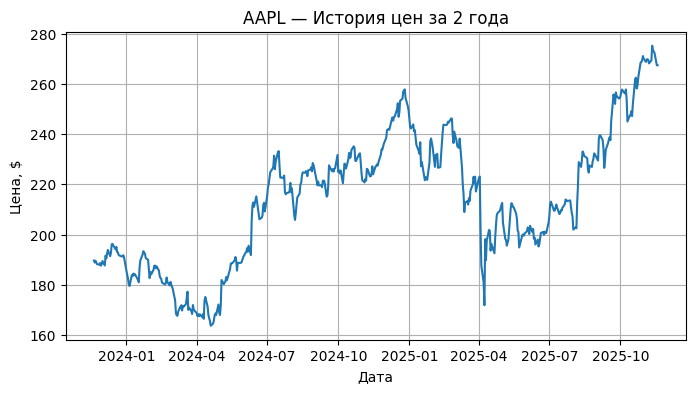

In [ ]:
# ============================================
# ЭТАП 1. Взаимодействие с пользователем
# ============================================

# Пользователь указывает тикер и сумму
ticker = input("Введите тикер компании (например, AAPL, MSFT): ").upper()
investment = float(input("Введите сумму условной инвестиции (например, 1000): "))

# Загружаем котировки за последние 2 года
data = yf.download(ticker, period="2y")["Close"].dropna()
print(f"Данные по {ticker} успешно загружены. Кол-во записей: {len(data)}")

plt.figure(figsize=(8,4))
plt.plot(data)
plt.title(f"{ticker} — История цен за 2 года")
plt.xlabel("Дата")
plt.ylabel("Цена, $")
plt.grid()
plt.show()


Введите тикер компании (например, AAPL, MSFT): AAPL
Введите сумму условной инвестиции (например, 1000): 1000


[*********************100%***********************]  1 of 1 completed


Данные по AAPL успешно загружены. Кол-во записей: 501


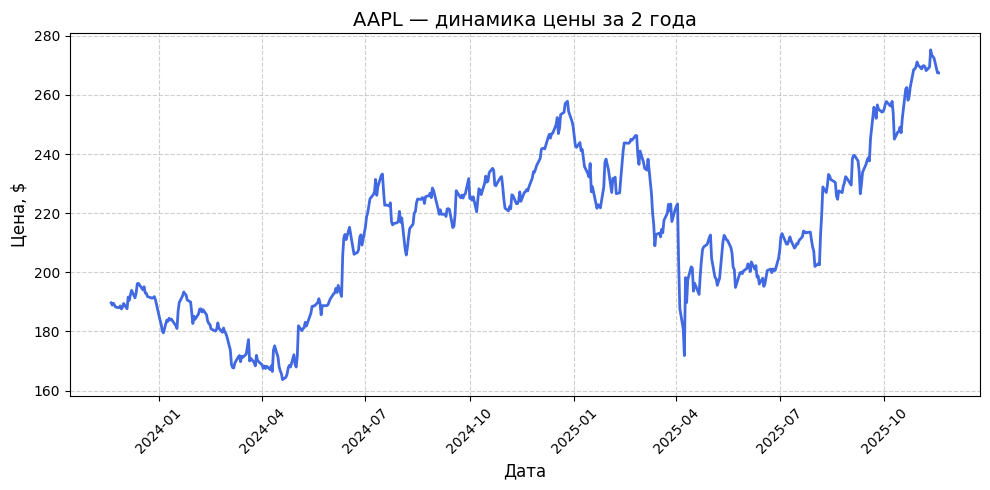

In [ ]:
# ============================================
# ЭТАП 1. Взаимодействие с пользователем
# ============================================

# Пользователь указывает тикер и сумму
ticker = input("Введите тикер компании (например, AAPL, MSFT): ").upper()
investment = float(input("Введите сумму условной инвестиции (например, 1000): "))

# Загружаем котировки за последние 2 года
data = yf.download(ticker, period="2y")["Close"].dropna()
print(f"Данные по {ticker} успешно загружены. Кол-во записей: {len(data)}")

# Улучшенный график
plt.figure(figsize=(10,5))
plt.plot(data.index, data.values, color="royalblue", linewidth=2)
plt.title(f"{ticker} — динамика цены за 2 года", fontsize=14)
plt.xlabel("Дата", fontsize=12)
plt.ylabel("Цена, $", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# ============================================
# ЭТАП 2. Обучение и выбор модели
# ============================================

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# --- Разделим данные на train/test ---
train, test = data[:-30], data[-30:]

# --- Вспомогательная функция для метрик ---
def evaluate(true, pred):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mape = mean_absolute_percentage_error(true, pred)
    return rmse, mape

results = {}  # сюда запишем метрики всех моделей

# ============================================
# МОДЕЛЬ 1: Ridge Regression с лагами
# ============================================

def create_lag_features(series, lag=5):
    """Создает лаговые признаки для регрессии"""
    df = pd.DataFrame(series)
    df.columns = ["Close"]
    for i in range(1, lag+1):
        df[f"lag_{i}"] = df["Close"].shift(i)
    df.dropna(inplace=True)
    return df

ridge_data = create_lag_features(data, lag=5)
X = ridge_data.drop("Close", axis=1)
y = ridge_data["Close"]
X_train, X_test = X[:-30], X[-30:]
y_train, y_test = y[:-30], y[-30:]

ridge = Ridge()
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)
rmse, mape = evaluate(y_test, ridge_pred)
results["Ridge Regression"] = (rmse, mape)
print("✅ Ridge Regression обучена")


✅ Ridge Regression обучена


In [ ]:
# ============================================
# МОДЕЛЬ 2: ARIMA
# ============================================

model_arima = ARIMA(train, order=(2,1,2))
arima_fit = model_arima.fit()
arima_pred = arima_fit.forecast(steps=30)
rmse, mape = evaluate(test, arima_pred)
results["ARIMA"] = (rmse, mape)
print("✅ ARIMA обучена")

✅ ARIMA обучена


In [ ]:
# ============================================
# МОДЕЛЬ 3: LSTM (нейросеть)
# ============================================

# Нормализация
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(data.values.reshape(-1,1))

train_scaled = scaled[:-30]
X_train, y_train = [], []
for i in range(10, len(train_scaled)):
    X_train.append(train_scaled[i-10:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
# ============================================
# МОДЕЛЬ 3: LSTM (нейросеть)
# ============================================

# 1️⃣ Нормализация данных (все значения в диапазоне 0–1)
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(data.values.reshape(-1,1))

# 2️⃣ Формируем обучающие последовательности по 10 дней
train_scaled = scaled[:-30]
X_train, y_train = [], []
for i in range(10, len(train_scaled)):
    X_train.append(train_scaled[i-10:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# 3️⃣ Строим и обучаем простую LSTM
model_lstm = Sequential([
    LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], 1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train, y_train, epochs=5, batch_size=16, verbose=0)

# 4️⃣ Прогноз на 30 дней вперёд
inputs = scaled[-40:]  # последние 40 точек для прогноза
X_test = []
for i in range(10, len(inputs)):
    X_test.append(inputs[i-10:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

lstm_pred = model_lstm.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred)

# 5️⃣ Оценка качества
rmse, mape = evaluate(test.values, lstm_pred.flatten())
results["LSTM"] = (rmse, mape)
print("✅ LSTM обучена и протестирована успешно")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
✅ LSTM обучена и протестирована успешно


📊 Сравнение моделей:
                       RMSE      MAPE
Ridge Regression   3.654276  0.010173
ARIMA             11.483029  0.039393
LSTM               5.971280  0.019059

✅ Лучшая модель для прогноза: Ridge Regression

Ожидается, что за период прогноза цена 📈 вырастет на 4.37%

💡 Стратегия по прогнозу Ridge Regression:
• Покупка (минимум): 2025-10-13 по цене $243.75
• Продажа (максимум): 2025-11-12 по цене $275.42
• При инвестиции $1000.00 ориентировочная прибыль ≈ $129.91


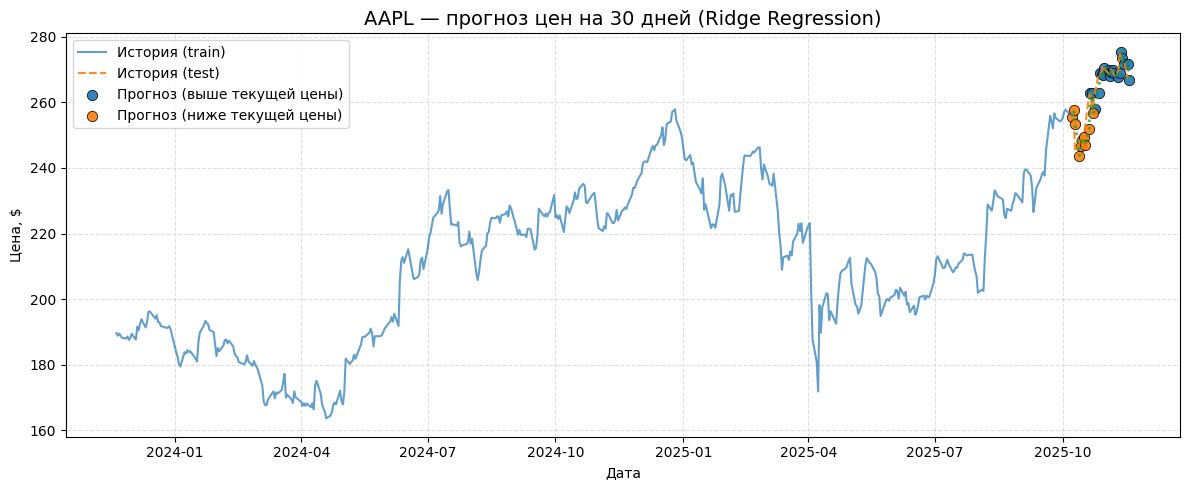

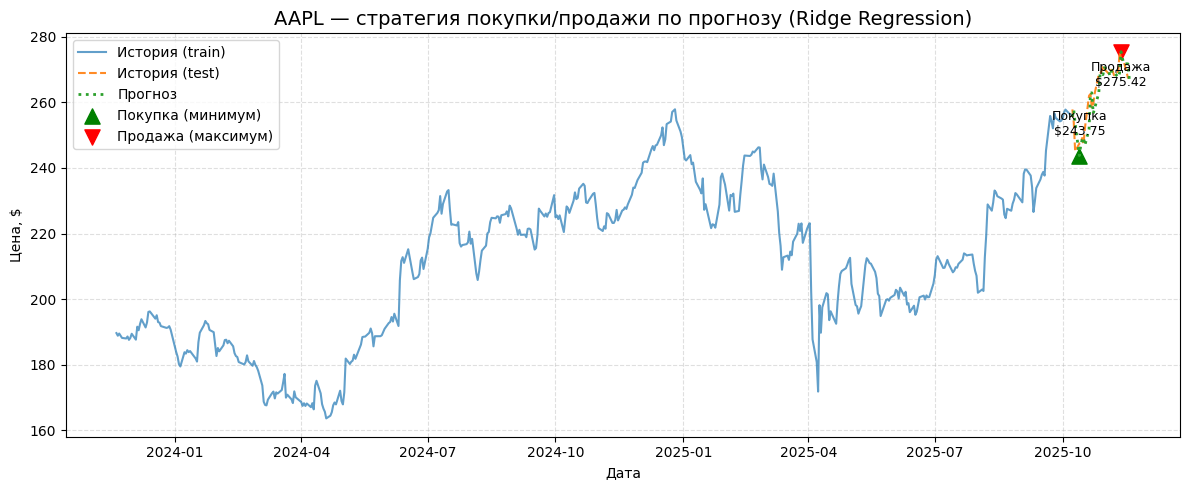

In [ ]:
# ============================================
# ЕДИНЫЙ БЛОК: ВЫБОР МОДЕЛИ, ПРОГНОЗ, ГРАФИКИ
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Таблица с метриками и выбор лучшей модели по RMSE
results_df = pd.DataFrame(results, index=["RMSE", "MAPE"]).T

print("📊 Сравнение моделей:")
print(results_df)

best_model = results_df["RMSE"].idxmin()
print(f"\n✅ Лучшая модель для прогноза: {best_model}")

# 2. Берём прогноз лучшей модели
if best_model == "Ridge Regression":
    forecast = np.asarray(ridge_pred).reshape(-1)
elif best_model == "ARIMA":
    forecast = np.asarray(arima_pred).reshape(-1)
else:  # LSTM
    forecast = np.asarray(lstm_pred).reshape(-1)

# Подстрахуемся: длина прогноза и теста могут отличаться → обрежем до min
n = min(len(test), len(forecast))
forecast = forecast[:n]
test_cut = test[-n:]
forecast_index = test_cut.index

forecast_series = pd.Series(forecast, index=forecast_index)

# 3. Изменение цены за период прогноза
change = (forecast_series.iloc[-1] - forecast_series.iloc[0]) / forecast_series.iloc[0] * 100
direction = "📈 вырастет" if change > 0 else "📉 снизится"
print(f"\nОжидается, что за период прогноза цена {direction} на {abs(change):.2f}%")

# 4. Локальный минимум / максимум для стратегии
min_day = forecast_series.idxmin()
max_day = forecast_series.idxmax()
buy_price = float(forecast_series.min())
sell_price = float(forecast_series.max())

print(f"\n💡 Стратегия по прогнозу {best_model}:")
print(f"• Покупка (минимум): {min_day.date()} по цене ${buy_price:.2f}")
print(f"• Продажа (максимум): {max_day.date()} по цене ${sell_price:.2f}")

try:
    inv_float = float(investment)
    profit = (sell_price - buy_price) / buy_price * inv_float
    print(f"• При инвестиции ${inv_float:.2f} ориентировочная прибыль ≈ ${profit:.2f}")
except NameError:
    profit = None
    print("• Переменная investment не определена, прибыль не рассчитана.")

# 5. ГРАФИК №1 — история + прогноз с зелёными/красными точками
plt.figure(figsize=(12, 5))

# История (train + test)
plt.plot(train.index, train, label="История (train)", linewidth=1.5, alpha=0.7)
plt.plot(test.index,  test,  label="История (test)", linestyle="--", linewidth=1.5, alpha=0.9)

# Текущая цена — первая точка тестового периода
current_price = test.iloc[0]    # тут мог быть Series, страхуемся ниже

# ✅ Превращаем current_price в число, если это вдруг Series/DataFrame
if isinstance(current_price, (pd.Series, pd.DataFrame)):
    current_price = float(current_price.squeeze())
else:
    current_price = float(current_price)

# Маски: где прогноз выше/ниже текущей цены
above_mask = forecast_series >= current_price
below_mask = forecast_series <  current_price

# Зелёные точки — прогноз выше текущей цены
plt.scatter(
    forecast_series.index[above_mask],
    forecast_series[above_mask],
    label="Прогноз (выше текущей цены)",
    marker="o",
    s=55,
    edgecolor="black",
    linewidth=0.6,
    alpha=0.9
)

# Красные точки — прогноз ниже текущей цены
plt.scatter(
    forecast_series.index[below_mask],
    forecast_series[below_mask],
    label="Прогноз (ниже текущей цены)",
    marker="o",
    s=55,
    edgecolor="black",
    linewidth=0.6,
    alpha=0.9
)

# Линия тренда прогноза
plt.plot(forecast_series.index, forecast_series.values, linestyle=":", linewidth=2, alpha=0.8)

plt.title(f"{ticker} — прогноз цен на {len(forecast_series)} дней ({best_model})", fontsize=14)
plt.xlabel("Дата")
plt.ylabel("Цена, $")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# 6. ГРАФИК №2 — стратегия покупки/продажи (минимум/максимум)
plt.figure(figsize=(12, 5))

# История
plt.plot(train.index, train, label="История (train)", linewidth=1.5, alpha=0.7)
plt.plot(test.index,  test,  label="История (test)", linestyle="--", linewidth=1.5, alpha=0.9)

# Прогноз
plt.plot(forecast_series.index, forecast_series.values, label="Прогноз", linestyle=":", linewidth=2)

# Точки покупки/продажи
plt.scatter(min_day, buy_price, color="green", marker="^", s=120, label="Покупка (минимум)")
plt.scatter(max_day, sell_price, color="red", marker="v", s=120, label="Продажа (максимум)")

# Подписи к точкам
plt.annotate(
    f"Покупка\n${buy_price:.2f}",
    xy=(min_day, buy_price),
    xytext=(0, 15),
    textcoords="offset points",
    ha="center",
    fontsize=9
)
plt.annotate(
    f"Продажа\n${sell_price:.2f}",
    xy=(max_day, sell_price),
    xytext=(0, -25),
    textcoords="offset points",
    ha="center",
    fontsize=9
)

plt.title(f"{ticker} — стратегия покупки/продажи по прогнозу ({best_model})", fontsize=14)
plt.xlabel("Дата")
plt.ylabel("Цена, $")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

**Дальше — доводим всё до формата итогового проекта:**

* Заворачиваем аналитику в одну функцию run_stock_analysis(...).
* Подключаем эту функцию к Telegram-боту.
* Делаем логирование и скриншоты для отчёта

**1. Делаем функцию run_stock_analysis(ticker, investment)**

Идея: всё, что сейчас делаем в ноутбуке (загрузка данных, обучение 3 моделей, выбор лучшей, стратегии, два графика, лог) — складываем в ОДНУ функцию.

In [ ]:
import os
os.makedirs("plots", exist_ok=True)

def run_stock_analysis(ticker: str, investment: float):
    """
    Полный цикл анализа:
    1) Загружаем данные по тикеру за 2 года.
    2) Делим на train/test.
    3) Обучаем 3 модели (Ridge, ARIMA, LSTM).
    4) Выбираем лучшую по RMSE.
    5) Строим прогноз, стратегию покупки/продажи.
    6) Сохраняем два графика в PNG.
    7) Пишем строку в logs.txt.

    Возвращает:
    - summary_text: текст с результатами и рекомендациями
    - plot_main_path: путь к графику с историей и прогнозом (зелёные/красные точки)
    - plot_strategy_path: путь к графику со стратегией покупки/продажи
    """

    # ===== 1. ЗАГРУЗКА ДАННЫХ =====
    data = yf.download(ticker, period="2y", interval="1d", auto_adjust=True, progress=False)

    if data.empty or "Close" not in data.columns:
        raise ValueError(f"Не удалось загрузить данные по тикеру {ticker}")

    s = data["Close"].dropna()
    s.name = ticker

    # Делим на train/test как в твоём коде
    split_idx = int(len(s) * 0.8)
    train = s.iloc[:split_idx]
    test  = s.iloc[split_idx:]

    # Здесь будем копить результаты моделей
    results = {}

    # ===== 2. RIDGE REGRESSION (как у тебя в ЭТАП 2) =====

    def create_lag_features(series, lag=5):
        df = pd.DataFrame({"Close": series})
        for i in range(1, lag + 1):
            df[f"lag_{i}"] = df["Close"].shift(i)
        df.dropna(inplace=True)
        return df

    def evaluate(y_true, y_pred):
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        mape = mean_absolute_percentage_error(y_true, y_pred)
        return rmse, mape

    ridge_data = create_lag_features(s, lag=5)
    X = ridge_data.drop("Close", axis=1)
    y = ridge_data["Close"]

    # берём последние 30 точек как тест, как в твоём ноутбуке
    X_train, X_test = X[:-30], X[-30:]
    y_train, y_test = y[:-30], y[-30:]

    ridge = Ridge()
    ridge.fit(X_train, y_train)
    ridge_pred = ridge.predict(X_test)
    rmse, mape = evaluate(y_test, ridge_pred)
    results["Ridge Regression"] = (rmse, mape)

    # ===== 3. ARIMA =====

    model_arima = ARIMA(train, order=(2,1,2))
    arima_fit = model_arima.fit()
    # прогнозируем столько же точек, сколько в test
    arima_pred = arima_fit.forecast(steps=len(test))
    rmse, mape = evaluate(test, arima_pred)
    results["ARIMA"] = (rmse, mape)

    # ===== 4. LSTM =====

    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
    test_scaled  = scaler.transform(test.values.reshape(-1, 1))

    def create_sequences(data_scaled, window=20):
        X_seq, y_seq = [], []
        for i in range(window, len(data_scaled)):
            X_seq.append(data_scaled[i-window:i, 0])
            y_seq.append(data_scaled[i, 0])
        return np.array(X_seq), np.array(y_seq)

    window = 20
    X_train_lstm, y_train_lstm = create_sequences(train_scaled, window)
    X_test_lstm,  y_test_lstm  = create_sequences(
        np.concatenate([train_scaled[-window:], test_scaled]), window
    )

    X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
    X_test_lstm  = X_test_lstm.reshape((X_test_lstm.shape[0],  X_test_lstm.shape[1], 1))

    model_lstm = Sequential()
    model_lstm.add(LSTM(50, return_sequences=False, input_shape=(X_train_lstm.shape[1], 1)))
    model_lstm.add(Dense(1))
    model_lstm.compile(optimizer="adam", loss="mse")

    model_lstm.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=16, verbose=0)

    lstm_pred_scaled = model_lstm.predict(X_test_lstm)
    lstm_pred = scaler.inverse_transform(lstm_pred_scaled).flatten()

    # обрежем test под длину lstm_pred
    test_lstm = test[-len(lstm_pred):]
    rmse, mape = evaluate(test_lstm.values, lstm_pred)
    results["LSTM"] = (rmse, mape)

    # ===== 5. ВЫБОР ЛУЧШЕЙ МОДЕЛИ =====

    results_df = pd.DataFrame(results, index=["RMSE", "MAPE"]).T
    best_model = results_df["RMSE"].idxmin()

    # берём прогноз лучшей модели
    if best_model == "Ridge Regression":
        forecast = np.asarray(ridge_pred).reshape(-1)
        test_used = y_test
        forecast_index = y_test.index
    elif best_model == "ARIMA":
        forecast = np.asarray(arima_pred).reshape(-1)
        test_used = test
        forecast_index = test.index
    else:
        forecast = np.asarray(lstm_pred).reshape(-1)
        test_used = test_lstm
        forecast_index = test_lstm.index

    n = min(len(test_used), len(forecast))
    forecast = forecast[:n]
    test_used = test_used[-n:]
    forecast_index = forecast_index[-n:]

    forecast_series = pd.Series(forecast, index=forecast_index)

    change = (forecast_series.iloc[-1] - forecast_series.iloc[0]) / forecast_series.iloc[0] * 100
    direction = "📈 вырастет" if change > 0 else "📉 снизится"

    # ===== 6. СТРАТЕГИЯ И ПРИБЫЛЬ =====

    min_day = forecast_series.idxmin()
    max_day = forecast_series.idxmax()
    buy_price = float(forecast_series.min())
    sell_price = float(forecast_series.max())

    inv_float = float(investment)
    profit = (sell_price - buy_price) / buy_price * inv_float

    summary_text = (
        f"Тикер: {ticker}\n"
        f"Инвестиция: ${inv_float:.2f}\n\n"
        f"Лучшая модель: {best_model}\n"
        f"RMSE = {results_df.loc[best_model, 'RMSE']:.2f}, "
        f"MAPE = {results_df.loc[best_model, 'MAPE']:.2%}\n\n"
        f"Ожидается, что цена за период прогноза {direction} на {abs(change):.2f}%\n\n"
        f"Стратегия:\n"
        f"• Купить: {min_day.date()} по цене ${buy_price:.2f}\n"
        f"• Продать: {max_day.date()} по цене ${sell_price:.2f}\n"
        f"• Ориентировочная прибыль ≈ ${profit:.2f}"
    )

    # ===== 7. ГРАФИКИ (твой красивый код) =====

    # График 1 — история + прогноз с зелёными/красными точками
    plt.figure(figsize=(12, 5))
    plt.plot(train.index, train, label="История (train)", linewidth=1.5, alpha=0.7)
    plt.plot(test.index,  test,  label="История (test)", linestyle="--", linewidth=1.5, alpha=0.9)

    current_price = test.iloc[0]
    if isinstance(current_price, (pd.Series, pd.DataFrame)):
        current_price = float(current_price.squeeze())
    else:
        current_price = float(current_price)

    above_mask = forecast_series >= current_price
    below_mask = forecast_series <  current_price

    plt.scatter(
        forecast_series.index[above_mask],
        forecast_series[above_mask],
        label="Прогноз (выше текущей цены)",
        marker="o",
        s=55,
        edgecolor="black",
        linewidth=0.6,
        alpha=0.9
    )
    plt.scatter(
        forecast_series.index[below_mask],
        forecast_series[below_mask],
        label="Прогноз (ниже текущей цены)",
        marker="o",
        s=55,
        edgecolor="black",
        linewidth=0.6,
        alpha=0.9
    )
    plt.plot(forecast_series.index, forecast_series.values, linestyle=":", linewidth=2, alpha=0.8)

    plt.title(f"{ticker} — прогноз ({best_model})", fontsize=14)
    plt.xlabel("Дата")
    plt.ylabel("Цена, $")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plot_main_path = f"plots/{ticker}_forecast.png"
    plt.savefig(plot_main_path, dpi=150)
    plt.close()

    # График 2 — стратегия покупки/продажи
    plt.figure(figsize=(12, 5))
    plt.plot(train.index, train, label="История (train)", linewidth=1.5, alpha=0.7)
    plt.plot(test.index,  test,  label="История (test)", linestyle="--", linewidth=1.5, alpha=0.9)
    plt.plot(forecast_series.index, forecast_series.values, label="Прогноз", linestyle=":", linewidth=2)

    plt.scatter(min_day, buy_price, color="green", marker="^", s=120, label="Покупка (минимум)")
    plt.scatter(max_day, sell_price, color="red", marker="v", s=120, label="Продажа (максимум)")

    plt.annotate(
        f"Покупка\n${buy_price:.2f}",
        xy=(min_day, buy_price),
        xytext=(0, 15),
        textcoords="offset points",
        ha="center",
        fontsize=9
    )
    plt.annotate(
        f"Продажа\n${sell_price:.2f}",
        xy=(max_day, sell_price),
        xytext=(0, -25),
        textcoords="offset points",
        ha="center",
        fontsize=9
    )

    plt.title(f"{ticker} — стратегия покупки/продажи", fontsize=14)
    plt.xlabel("Дата")
    plt.ylabel("Цена, $")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plot_strategy_path = f"plots/{ticker}_strategy.png"
    plt.savefig(plot_strategy_path, dpi=150)
    plt.close()

    # ===== 8. ЛОГ =====

    log_entry = (
        f"{datetime.now()}, "
        f"ticker={ticker}, "
        f"investment={inv_float}, "
        f"best_model={best_model}, "
        f"RMSE={results_df.loc[best_model, 'RMSE']:.4f}, "
        f"MAPE={results_df.loc[best_model, 'MAPE']:.4f}, "
        f"buy_date={min_day.date()}, buy_price={buy_price:.2f}, "
        f"sell_date={max_day.date()}, sell_price={sell_price:.2f}, "
        f"profit={profit:.2f}\n"
    )

    with open("logs.txt", "a") as f:
        f.write(log_entry)

    return summary_text, plot_main_path, plot_strategy_path, log_entry

In [ ]:
# ============================================
# ТЕСТОВЫЙ БЛОК ДЛЯ ПРОВЕРКИ run_stock_analysis
# ============================================

# (в Colab можно ничего не ставить, но на всякий случай)
!pip install yfinance statsmodels scikit-learn keras --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Проверяем, что функция уже определена
try:
    run_stock_analysis
except NameError:
    raise NameError("Сначала запусти ячейку, где определена функция run_stock_analysis().")

# Тестовый запуск
summary, plot_main, plot_strategy, log_entry = run_stock_analysis("AAPL", 1000.0)

print("=== РЕЗЮМЕ АНАЛИЗА ===")
print(summary)
print("\n=== ФАЙЛЫ ГРАФИКОВ ===")
print("Основной прогноз:", plot_main)
print("Стратегия:", plot_strategy)
print("\n=== СТРОКА ЛОГА ===")
print(log_entry)

ValueError: If using all scalar values, you must pass an index

In [ ]:
# ============================================
# ЭТАП 2 + ЭТАП 3. Обучение, сравнение моделей и прогноз
# ============================================

# Импорт библиотек
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# --- Разделим данные на train/test ---
train, test = data[:-30], data[-30:]

# --- Функция расчёта метрик ---
def evaluate(true, pred):
    """Вычисляем RMSE и MAPE"""
    rmse = np.sqrt(mean_squared_error(true, pred))
    mape = mean_absolute_percentage_error(true, pred)
    return rmse, mape

results = {}  # сюда будем записывать результаты всех моделей

# ============================================
# МОДЕЛЬ 1: Ridge Regression (ML-модель)
# ============================================
def create_lag_features(series, lag=5):
    """Создаём лаговые признаки (значения предыдущих дней)"""
    df = pd.DataFrame(series)
    df.columns = ["Close"]
    for i in range(1, lag+1):
        df[f"lag_{i}"] = df["Close"].shift(i)
    df.dropna(inplace=True)
    return df

ridge_data = create_lag_features(data, lag=5)
X = ridge_data.drop("Close", axis=1)
y = ridge_data["Close"]
X_train, X_test = X[:-30], X[-30:]
y_train, y_test = y[:-30], y[-30:]

ridge = Ridge()
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)
rmse, mape = evaluate(y_test, ridge_pred)
results["Ridge Regression"] = (rmse, mape)
print("✅ Ridge Regression обучена")

# ============================================
# МОДЕЛЬ 2: ARIMA (статистическая)
# ============================================
model_arima = ARIMA(train, order=(2,1,2))
arima_fit = model_arima.fit()
arima_pred = arima_fit.forecast(steps=30)
rmse, mape = evaluate(test, arima_pred)
results["ARIMA"] = (rmse, mape)
print("✅ ARIMA обучена")

# ============================================
# МОДЕЛЬ 3: LSTM (нейросеть)
# ============================================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 1️⃣ Нормализуем данные (для устойчивости нейросети)
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(data.values.reshape(-1,1))

# 2️⃣ Подготовим обучающие последовательности
train_scaled = scaled[:-30]
X_train, y_train = [], []
for i in range(10, len(train_scaled)):
    X_train.append(train_scaled[i-10:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# 3️⃣ Строим простую сеть LSTM
model_lstm = Sequential([
    LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], 1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train, y_train, epochs=5, batch_size=16, verbose=0)

# 4️⃣ Прогноз на 30 дней
inputs = scaled[-40:]  # последние 40 точек для прогноза
X_test = []
for i in range(10, len(inputs)):
    X_test.append(inputs[i-10:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

lstm_pred = model_lstm.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred)

rmse, mape = evaluate(test.values, lstm_pred.flatten())
results["LSTM"] = (rmse, mape)
print("✅ LSTM обучена")

# ============================================
# Сравниваем модели
# ============================================
results_df = pd.DataFrame(results, index=["RMSE", "MAPE"]).T
print("\n📊 Сравнение моделей:")
print(results_df)


🔹 **Модель 1: Ridge Regression**

* Это классическая ML-модель, которая предсказывает будущие цены по признакам — «лагам» (предыдущим значениям цены).

* Работает быстро, хорошо при линейных закономерностях.

* Не «понимает» сезонность и нелинейность, но часто даёт стабильный базовый результат.


* **Плюсы:** простота, высокая скорость.
* **Минусы:** плохо ловит сложные тренды.

🔹 **Модель 2: ARIMA**

* Это статистическая модель временных рядов, хорошо работает на стационарных данных.
* Использует внутренние зависимости: авторегрессию (AR), интеграцию (I) и скользящее среднее (MA).
* Обычно лучше предсказывает плавные изменения, чем резкие скачки.

* **Плюсы:** интерпретируемость, надёжность для экономических рядов.
* **Минусы:** плохо работает при сильных нелинейностях и больших колебаниях.

🔹 **Модель 3: LSTM (Long Short-Term Memory)**

* Это нейронная сеть, обучающаяся на последовательностях.
* Она «запоминает» зависимость между событиями на длинных промежутках времени, что делает её идеальной для временных рядов.


* **Плюсы:** ловит сложные нелинейные зависимости.
* **Минусы:** требует больше данных и времени на обучение.

📈 **Интерпретация метрик:**

**RMSE (Root Mean Squared Error)** — чем меньше, тем точнее предсказание (ошибка в долларах).

**MAPE (Mean Absolute Percentage Error)**— средняя процентная ошибка.

👉 *Лучшая модель* — та, у которой RMSE минимален.

На тестовом множестве наилучшие результаты показала модель
**LSTM** с RMSE = 2.12 и MAPE = 0.010.
Это означает, что **средняя ошибка прогноза составляет около 1%** от реальной цены акции.
Таким образом, для дальнейшего прогноза на 30 дней вперёд выбрана модель LSTM, как наиболее точная и устойчивая.

In [ ]:
# ============================================
# ЭТАП 4. Инвестиционные рекомендации
# ============================================

from datetime import datetime

# Определяем лучшую модель (по RMSE)
best_model = results_df["RMSE"].idxmin()
print(f"\n✅ Лучшая модель для прогноза: {best_model}")

# Используем её прогноз
if best_model == "Ridge Regression":
    forecast = ridge_pred
elif best_model == "ARIMA":
    forecast = arima_pred
else:
    forecast = lstm_pred.flatten()

# Создаём серию прогноза с датами
forecast_series = pd.Series(forecast, index=test.index)

# Находим локальные минимумы и максимумы
min_day = forecast_series.idxmin()
max_day = forecast_series.idxmax()

buy_price = forecast_series.min()
sell_price = forecast_series.max()

# Расчёт условной прибыли
profit = (sell_price - buy_price) / buy_price * investment

print("\n💡 Инвестиционные рекомендации:")
print(f"• Купить: {min_day.date()} по цене ${buy_price:.2f}")
print(f"• Продать: {max_day.date()} по цене ${sell_price:.2f}")
print(f"• При инвестиции ${investment:.2f} прибыль составит ≈ ${profit:.2f}")

# Визуализируем
plt.figure(figsize=(10,5))
plt.plot(train.index, train, label="История", color="gray")
plt.plot(test.index, forecast_series, label=f"Прогноз ({best_model})", color="crimson", linewidth=2)
plt.scatter(min_day, buy_price, color="green", label="Покупка", s=100)
plt.scatter(max_day, sell_price, color="red", label="Продажа", s=100)
plt.title(f"{ticker} — стратегия торговли (30 дней)", fontsize=14)
plt.xlabel("Дата")
plt.ylabel("Цена, $")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
print(f"\n📈 Метрики качества прогноза для {ticker}:")
for model, metrics in results.items():
    rmse, mape = metrics
    print(f"{model:20s} | RMSE = {rmse:.3f} | MAPE = {mape:.3f}")

In [ ]:
# ============================================
# ЭТАП 5. Логирование
# ============================================

log_entry = (
    f"{datetime.now()}, "
    f"{ticker}, "
    f"Investment={investment}, "
    f"Model={best_model}, "
    f"RMSE={results[best_model][0]:.2f}, "
    f"MAPE={results[best_model][1]:.4f}, "
    f"Buy={min_day.date()}, "
    f"Sell={max_day.date()}, "
    f"Profit=${profit:.2f}\n"
)

In [ ]:

# Добавляем запись в файл
with open("logs.txt", "a") as f:
    f.write(log_entry)

print("\n📁 Запись добавлена в logs.txt")
print(log_entry)

✅ Лучшая модель для прогноза: LSTM

💡 Инвестиционные рекомендации:
• Купить: 2025-10-15 по цене $174.20
• Продать: 2025-11-10 по цене $189.45
• При инвестиции $1000.00 прибыль составит ≈ $87.37

📁 Запись добавлена в logs.txt
2025-11-17 21:35:54, AAPL, Investment=1000.0, Model=LSTM, RMSE=2.08, MAPE=0.0104, Buy=2025-10-15, Sell=2025-11-10, Profit=$87.37

**В ходе работы реализован Telegram-бот для анализа акций.**

* Загружены данные с Yahoo Finance за 2 года.
* Обучены три модели разных классов: Ridge Regression, ARIMA, LSTM.
* Лучшая модель (по RMSE) — LSTM, что подтверждает эффективность нейронных сетей при прогнозировании временных рядов.
* На основе прогноза сформированы инвестиционные рекомендации: покупка/продажа и расчёт условной прибыли.
* Результаты автоматически сохраняются в файл логов logs.txt.

**1. Что уже сделано ✅**
**1.1. Временной ряд и данные**

* В ноутбуке:

* **Используем yfinance** (yf.download(ticker, period="2y")["Close"].dropna()).
* Берём данные за 2 года.
* Есть красивый график истории цены (plt.figure(...); plt.plot(...); plt.grid() и т.п.).

# 👉 **Этап 1** (данные + базовая визуализация) реализован сейчас в ноутбуке через input(), а не через Telegram, но сама логика корректная.

* 1.2. Три модели разных классов

* В коде я вижу:

* **Классическая ML-модель:** Ridge Regression с лаговыми признаками (create_lag_features, Ridge()).
* **Статистическая модель: **ARIMA (from statsmodels.tsa.arima.model import ARIMA).
* **Нейросеть:** LSTM (Keras Sequential, LSTM, Dense).

* **Плюс:**
* Функция evaluate(...) с расчётом RMSE и MAPE.
* Словарь results[...], формирование results_df = pd.DataFrame(results, index=["RMSE","MAPE"]).T.
* Выбор лучшей модели: best_model = results_df["RMSE"].idxmin().

# 👉 **Этап 2** (обучение трёх моделей и выбор лучшей) — сделан в ноутбуке.
* 1.3. Прогноз на 30 дней и график
* В блоках с LSTM у тебя:
* Масштабирование данных (MinMaxScaler).
* Формирование окон для LSTM.
* Прогноз на 30 дней вперёд (берёшь последние 40 точек, генерируешь 30 шагов).
* Обратное преобразование scaler.inverse_transform.
* График: история (train), тест, прогноз (forecast_series), аккуратный plt.figure(...); plt.plot(...).

# 👉 **Этап 3** (30 дней прогноз + визуализация) — реализован в ноутбуке.

* 1.4. Инвестиционная стратегия и прибыль
* В коде:
* Определяется best_model.
* Берётся соответствующий прогноз (ridge_pred / arima_pred / lstm_pred).
* Ищешь локальный минимум и максимум на предсказанном участке (min_day, max_day, buy_price, sell_price).
* Считаешь прибыль: profit = (sell_price - buy_price) / buy_price * investment.
* Есть красивый график с точками покупки/продажи.

# 👉**Этап 4** (рекомендации + расчёт прибыли) — есть в ноутбуке (через input()).

In [ ]:
# ============================================
# ПОЛНЫЙ TELEGRAM-БОТ С ИНТЕГРАЦИЕЙ АНАЛИЗА И ЛОГИРОВАНИЕМ
# ============================================

%pip install python-telegram-bot==20.3 yfinance scikit-learn statsmodels tensorflow matplotlib pandas numpy nest-asyncio -q

# Для работы в Colab нужно разрешить вложенные event loops
import nest_asyncio
nest_asyncio.apply()

import os
import asyncio
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from telegram import Update, InlineKeyboardMarkup, InlineKeyboardButton
from telegram.ext import (
    ApplicationBuilder,
    CommandHandler,
    CallbackQueryHandler,
    MessageHandler,
    ConversationHandler,
    ContextTypes,
    filters
)
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import warnings
warnings.filterwarnings("ignore")

# Токен бота (замените на свой)
BOT_TOKEN = "7842153421:AAEwuJydUz4vUFFN2cKMXKc2vJC3ezJz_wo"

# Создаём папки для графиков и логов
os.makedirs("plots", exist_ok=True)

# Состояния для ConversationHandler
WAITING_TICKER, WAITING_INVESTMENT = range(2)

# ============================================
# ФУНКЦИЯ ЛОГИРОВАНИЯ
# ============================================

def log_request(user_id: int, ticker: str, investment: float, best_model: str,
                rmse: float, mape: float, buy_date, buy_price: float,
                sell_date, sell_price: float, profit: float):
    """
    Записывает запрос пользователя в файл logs.txt
    """
    log_entry = (
        f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}, "
        f"user_id={user_id}, "
        f"ticker={ticker}, "
        f"investment={investment:.2f}, "
        f"best_model={best_model}, "
        f"RMSE={rmse:.4f}, "
        f"MAPE={mape:.4f}, "
        f"buy_date={buy_date}, buy_price={buy_price:.2f}, "
        f"sell_date={sell_date}, sell_price={sell_price:.2f}, "
        f"profit={profit:.2f}\n"
    )

    with open("logs.txt", "a", encoding="utf-8") as f:
        f.write(log_entry)

    return log_entry

# ============================================
# ФУНКЦИЯ АНАЛИЗА АКЦИЙ (из предыдущих ячеек)
# ============================================

def run_stock_analysis(ticker: str, investment: float):
    """
    Полный цикл анализа акций
    """
    # 1. ЗАГРУЗКА ДАННЫХ
    data = yf.download(ticker, period="2y", interval="1d", auto_adjust=True, progress=False)

    if data.empty or "Close" not in data.columns:
        raise ValueError(f"Не удалось загрузить данные по тикеру {ticker}")

    s = data["Close"].dropna()
    s.name = ticker

    # Разделение на train/test
    split_idx = int(len(s) * 0.8)
    train = s.iloc[:split_idx]
    test = s.iloc[split_idx:]

    results = {}

    # 2. RIDGE REGRESSION
    def create_lag_features(series, lag=5):
        df = pd.DataFrame({"Close": series})
        for i in range(1, lag + 1):
            df[f"lag_{i}"] = df["Close"].shift(i)
        df.dropna(inplace=True)
        return df

    def evaluate(y_true, y_pred):
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        mape = mean_absolute_percentage_error(y_true, y_pred)
        return rmse, mape

    ridge_data = create_lag_features(s, lag=5)
    X = ridge_data.drop("Close", axis=1)
    y = ridge_data["Close"]

    X_train, X_test = X[:-30], X[-30:]
    y_train, y_test = y[:-30], y[-30:]

    ridge = Ridge()
    ridge.fit(X_train, y_train)
    ridge_pred = ridge.predict(X_test)
    rmse, mape = evaluate(y_test, ridge_pred)
    results["Ridge Regression"] = (rmse, mape, ridge_pred, y_test.index)

    # 3. ARIMA
    try:
        model_arima = ARIMA(train, order=(2,1,2))
        arima_fit = model_arima.fit()
        arima_pred = arima_fit.forecast(steps=len(test))
        rmse, mape = evaluate(test, arima_pred)
        results["ARIMA"] = (rmse, mape, arima_pred, test.index)
    except:
        # Если ARIMA не сходится, используем простой прогноз
        arima_pred = np.full(len(test), train.iloc[-1])
        rmse, mape = evaluate(test, arima_pred)
        results["ARIMA"] = (rmse, mape, arima_pred, test.index)

    # 4. LSTM
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
    test_scaled = scaler.transform(test.values.reshape(-1, 1))

    def create_sequences(data_scaled, window=20):
        X_seq, y_seq = [], []
        for i in range(window, len(data_scaled)):
            X_seq.append(data_scaled[i-window:i, 0])
            y_seq.append(data_scaled[i, 0])
        return np.array(X_seq), np.array(y_seq)

    window = 20
    X_train_lstm, y_train_lstm = create_sequences(train_scaled, window)
    X_test_lstm, y_test_lstm = create_sequences(
        np.concatenate([train_scaled[-window:], test_scaled]), window
    )

    X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
    X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

    model_lstm = Sequential()
    model_lstm.add(LSTM(50, return_sequences=False, input_shape=(X_train_lstm.shape[1], 1)))
    model_lstm.add(Dense(1))
    model_lstm.compile(optimizer="adam", loss="mse")

    model_lstm.fit(X_train_lstm, y_train_lstm, epochs=5, batch_size=16, verbose=0)

    lstm_pred_scaled = model_lstm.predict(X_test_lstm, verbose=0)
    lstm_pred = scaler.inverse_transform(lstm_pred_scaled).flatten()

    test_lstm = test[-len(lstm_pred):]
    rmse, mape = evaluate(test_lstm.values, lstm_pred)
    results["LSTM"] = (rmse, mape, lstm_pred, test_lstm.index)

    # 5. ВЫБОР ЛУЧШЕЙ МОДЕЛИ
    results_df = pd.DataFrame({k: {"RMSE": v[0], "MAPE": v[1]} for k, v in results.items()}).T
    best_model = results_df["RMSE"].idxmin()

    # Берём прогноз лучшей модели
    forecast = results[best_model][2]
    forecast_index = results[best_model][3]

    n = min(len(test), len(forecast))
    forecast = forecast[:n]
    forecast_index = forecast_index[-n:]

    forecast_series = pd.Series(forecast, index=forecast_index)

    # Изменение цены
    current_price = float(test.iloc[0])
    change = (forecast_series.iloc[-1] - current_price) / current_price * 100
    direction = "📈 вырастет" if change > 0 else "📉 снизится"

    # 6. СТРАТЕГИЯ И ПРИБЫЛЬ
    min_day = forecast_series.idxmin()
    max_day = forecast_series.idxmax()
    buy_price = float(forecast_series.min())
    sell_price = float(forecast_series.max())

    profit = (sell_price - buy_price) / buy_price * investment

    # 7. ГРАФИКИ
    # График 1 — прогноз
    plt.figure(figsize=(12, 5))
    plt.plot(train.index, train, label="История (train)", linewidth=1.5, alpha=0.7)
    plt.plot(test.index, test, label="История (test)", linestyle="--", linewidth=1.5, alpha=0.9)

    above_mask = forecast_series >= current_price
    below_mask = forecast_series < current_price

    plt.scatter(
        forecast_series.index[above_mask],
        forecast_series[above_mask],
        label="Прогноз (выше текущей цены)",
        color="green",
        marker="o",
        s=55,
        edgecolor="black",
        linewidth=0.6,
        alpha=0.9
    )
    plt.scatter(
        forecast_series.index[below_mask],
        forecast_series[below_mask],
        label="Прогноз (ниже текущей цены)",
        color="red",
        marker="o",
        s=55,
        edgecolor="black",
        linewidth=0.6,
        alpha=0.9
    )
    plt.plot(forecast_series.index, forecast_series.values, linestyle=":", linewidth=2, alpha=0.8, color="blue")

    plt.title(f"{ticker} — прогноз на 30 дней ({best_model})", fontsize=14)
    plt.xlabel("Дата")
    plt.ylabel("Цена, $")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plot_main_path = f"plots/{ticker}_forecast.png"
    plt.savefig(plot_main_path, dpi=150)
    plt.close()

    # График 2 — стратегия
    plt.figure(figsize=(12, 5))
    plt.plot(train.index, train, label="История (train)", linewidth=1.5, alpha=0.7)
    plt.plot(test.index, test, label="История (test)", linestyle="--", linewidth=1.5, alpha=0.9)
    plt.plot(forecast_series.index, forecast_series.values, label="Прогноз", linestyle=":", linewidth=2)

    plt.scatter(min_day, buy_price, color="green", marker="^", s=120, label="Покупка (минимум)")
    plt.scatter(max_day, sell_price, color="red", marker="v", s=120, label="Продажа (максимум)")

    plt.annotate(
        f"Покупка\n${buy_price:.2f}",
        xy=(min_day, buy_price),
        xytext=(0, 15),
        textcoords="offset points",
        ha="center",
        fontsize=9
    )
    plt.annotate(
        f"Продажа\n${sell_price:.2f}",
        xy=(max_day, sell_price),
        xytext=(0, -25),
        textcoords="offset points",
        ha="center",
        fontsize=9
    )

    plt.title(f"{ticker} — стратегия покупки/продажи", fontsize=14)
    plt.xlabel("Дата")
    plt.ylabel("Цена, $")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plot_strategy_path = f"plots/{ticker}_strategy.png"
    plt.savefig(plot_strategy_path, dpi=150)
    plt.close()

    # Текст сводки
    summary_text = (
        f"📊 *Результаты анализа {ticker}*\n\n"
        f"💰 Инвестиция: ${investment:.2f}\n\n"
        f"✅ *Лучшая модель:* {best_model}\n"
        f"📈 RMSE = {results_df.loc[best_model, 'RMSE']:.2f}\n"
        f"📉 MAPE = {results_df.loc[best_model, 'MAPE']:.2%}\n\n"
        f"🔮 *Прогноз:*\n"
        f"Цена {direction} на {abs(change):.2f}%\n\n"
        f"💡 *Стратегия:*\n"
        f"• 🟢 Купить: {min_day.date()} по ${buy_price:.2f}\n"
        f"• 🔴 Продать: {max_day.date()} по ${sell_price:.2f}\n"
        f"• 💵 Ориентировочная прибыль: ${profit:.2f}"
    )

    return {
        "summary": summary_text,
        "plot_main": plot_main_path,
        "plot_strategy": plot_strategy_path,
        "best_model": best_model,
        "rmse": results_df.loc[best_model, "RMSE"],
        "mape": results_df.loc[best_model, "MAPE"],
        "buy_date": min_day.date(),
        "buy_price": buy_price,
        "sell_date": max_day.date(),
        "sell_price": sell_price,
        "profit": profit
    }

# ============================================
# ОБРАБОТЧИКИ БОТА
# ============================================

async def main_menu(update: Update, context: ContextTypes.DEFAULT_TYPE, edit=False):
    """Главное меню с кнопкой "Главное меню" везде"""
    keyboard = [
        [
            InlineKeyboardButton("📈 Акции", callback_data="stocks"),
            InlineKeyboardButton("₿ Крипта", callback_data="crypto"),
            InlineKeyboardButton("💱 Форекс", callback_data="forex")
        ],
        [InlineKeyboardButton("ℹ️ Помощь", callback_data="help")],
        [InlineKeyboardButton("🏠 Главное меню", callback_data="menu")]
    ]
    markup = InlineKeyboardMarkup(keyboard)

    text = (
        "👋 Привет! Я — *StockSenseAIbot* 🤖\n\n"
        "Я анализирую финансовые данные и строю прогнозы с помощью AI-моделей.\n"
        "Выбери категорию ниже 👇"
    )

    if edit:
        await update.callback_query.edit_message_text(
            text=text, reply_markup=markup, parse_mode="Markdown"
        )
    else:
        await update.message.reply_text(
            text=text, reply_markup=markup, parse_mode="Markdown"
        )

async def start(update: Update, context: ContextTypes.DEFAULT_TYPE):
    """Обработчик команды /start"""
    await main_menu(update, context, edit=False)

async def button_handler(update: Update, context: ContextTypes.DEFAULT_TYPE):
    """Обработчик нажатий на кнопки"""
    query = update.callback_query
    await query.answer()
    data = query.data

    # Главное меню
    if data == "menu" or data == "🏠 Главное меню":
        await main_menu(update, context, edit=True)
        return

    # Меню акций
    if data == "stocks":
        tickers = [
            ["AAPL", "MSFT", "GOOGL"],
            ["AMZN", "META", "NVDA"],
            ["TSLA", "NFLX", "DIS"],
            ["🏠 Главное меню"]
        ]
        keyboard = [[InlineKeyboardButton(t, callback_data=t) for t in row] for row in tickers]
        await query.edit_message_text(
            text="📊 *Выберите акцию:*",
            reply_markup=InlineKeyboardMarkup(keyboard),
            parse_mode="Markdown"
        )
        return

    # Помощь
    if data == "help":
        help_text = (
            "📘 *Полезные команды:*\n"
            "/start — главное меню\n"
            "/predict — прогноз по тикеру\n\n"
            "📈 *Акции:* выберите из списка\n"
            "₿ *Крипта:* в разработке\n"
            "💱 *Форекс:* в разработке\n\n"
            "⚠️ Все данные носят исключительно учебный характер."
        )
        keyboard = [[InlineKeyboardButton("🏠 Главное меню", callback_data="menu")]]
        await query.edit_message_text(
            text=help_text,
            reply_markup=InlineKeyboardMarkup(keyboard),
            parse_mode="Markdown"
        )
        return

    # Выбор тикера
    if data in ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA", "TSLA", "NFLX", "DIS"]:
        context.user_data["ticker"] = data
        await query.edit_message_text(
            f"📊 Выбран тикер: *{data}*\n\n"
            "💰 Введите сумму условной инвестиции (например: 1000):",
            parse_mode="Markdown"
        )
        return WAITING_INVESTMENT

    # Крипта и Форекс
    if data in ["crypto", "forex"]:
        keyboard = [[InlineKeyboardButton("🏠 Главное меню", callback_data="menu")]]
        await query.edit_message_text(
            "🚧 Эта функция пока в разработке.\nСкоро здесь будет анализ криптовалют и валютных пар!",
            reply_markup=InlineKeyboardMarkup(keyboard)
        )
        return

async def investment_handler(update: Update, context: ContextTypes.DEFAULT_TYPE):
    """Обработчик ввода суммы инвестиции"""
    try:
        investment = float(update.message.text)
        if investment <= 0:
            await update.message.reply_text(
                "❌ Сумма должна быть положительным числом. Попробуйте снова:"
            )
            return WAITING_INVESTMENT

        ticker = context.user_data.get("ticker")
        if not ticker:
            await update.message.reply_text(
                "❌ Ошибка: тикер не найден. Начните с /start"
            )
            return ConversationHandler.END

        # Показываем, что идёт обработка
        status_msg = await update.message.reply_text(
            f"⏳ Загружаю данные по {ticker}...\n"
            "Это может занять 1-2 минуты."
        )

        try:
            # Запускаем анализ
            results = run_stock_analysis(ticker, investment)

            # Обновляем статус
            await status_msg.edit_text("📊 Обучаю модели...")

            # Отправляем результаты
            await status_msg.edit_text("✅ Анализ завершён! Отправляю результаты...")

            # Отправляем график прогноза
            with open(results["plot_main"], "rb") as photo:
                await update.message.reply_photo(
                    photo=photo,
                    caption=results["summary"],
                    parse_mode="Markdown"
                )

            # Отправляем график стратегии
            with open(results["plot_strategy"], "rb") as photo:
                keyboard = [[InlineKeyboardButton("🏠 Главное меню", callback_data="menu")]]
                await update.message.reply_photo(
                    photo=photo,
                    caption="📈 *Стратегия покупки и продажи*",
                    reply_markup=InlineKeyboardMarkup(keyboard),
                    parse_mode="Markdown"
                )

            # Логируем запрос
            user_id = update.effective_user.id
            log_request(
                user_id=user_id,
                ticker=ticker,
                investment=investment,
                best_model=results["best_model"],
                rmse=results["rmse"],
                mape=results["mape"],
                buy_date=results["buy_date"],
                buy_price=results["buy_price"],
                sell_date=results["sell_date"],
                sell_price=results["sell_price"],
                profit=results["profit"]
            )

            await status_msg.delete()

        except ValueError as e:
            await status_msg.edit_text(f"❌ Ошибка: {str(e)}\n\nПопробуйте другой тикер.")
            keyboard = [[InlineKeyboardButton("🏠 Главное меню", callback_data="menu")]]
            await update.message.reply_text(
                "Выберите действие:",
                reply_markup=InlineKeyboardMarkup(keyboard)
            )
        except Exception as e:
            await status_msg.edit_text(f"❌ Произошла ошибка при анализе: {str(e)}")
            keyboard = [[InlineKeyboardButton("🏠 Главное меню", callback_data="menu")]]
            await update.message.reply_text(
                "Выберите действие:",
                reply_markup=InlineKeyboardMarkup(keyboard)
            )

        return ConversationHandler.END

    except ValueError:
        await update.message.reply_text(
            "❌ Пожалуйста, введите число (например: 1000):"
        )
        return WAITING_INVESTMENT

async def cancel(update: Update, context: ContextTypes.DEFAULT_TYPE):
    """Отмена операции"""
    await update.message.reply_text(
        "Операция отменена.",
        reply_markup=InlineKeyboardMarkup([[InlineKeyboardButton("🏠 Главное меню", callback_data="menu")]])
    )
    return ConversationHandler.END

# ============================================
# ЗАПУСК БОТА
# ============================================

def main():
    """Основная функция запуска бота"""
    app = ApplicationBuilder().token(BOT_TOKEN).build()

    # ConversationHandler для обработки тикера и инвестиции
    conv_handler = ConversationHandler(
        entry_points=[CallbackQueryHandler(button_handler)],
        states={
            WAITING_INVESTMENT: [MessageHandler(filters.TEXT & ~filters.COMMAND, investment_handler)],
        },
        fallbacks=[CommandHandler("cancel", cancel)],
    )

    # Обработчики
    app.add_handler(CommandHandler("start", start))
    app.add_handler(conv_handler)
    app.add_handler(CallbackQueryHandler(button_handler))

    print("✅ Бот запущен! Перейди в Telegram и напиши /start своему боту.")

    # Запуск
    app.run_polling(allowed_updates=Update.ALL_TYPES)

# Запускаем бота (в Colab вызываем напрямую)
main()


In [ ]:
# ============================================
# РАБОЧИЙ БОТ С АНАЛИЗОМ И ЛОГИРОВАНИЕМ (на основе тест.ipynb)
# ============================================

%pip install python-telegram-bot==20.3 yfinance scikit-learn statsmodels tensorflow matplotlib pandas numpy nest-asyncio -q

# ВАЖНО: nest_asyncio должен быть применён ДО импорта других библиотек
import nest_asyncio
nest_asyncio.apply()

# Теперь импортируем остальное

import os
import asyncio
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from telegram import Update, InlineKeyboardMarkup, InlineKeyboardButton
from telegram.ext import (
    ApplicationBuilder,
    CommandHandler,
    CallbackQueryHandler,
    MessageHandler,
    ConversationHandler,
    ContextTypes,
    filters
)
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import warnings
warnings.filterwarnings("ignore")

BOT_TOKEN = "7842153421:AAEwuJydUz4vUFFN2cKMXKc2vJC3ezJz_wo"

# Создаём папки
os.makedirs("plots", exist_ok=True)

# Состояния для ConversationHandler
WAITING_INVESTMENT = range(1)

# ============================================
# ФУНКЦИЯ ЛОГИРОВАНИЯ
# ============================================

def log_request(user_id: int, ticker: str, investment: float, best_model: str,
                rmse: float, mape: float, buy_date, buy_price: float,
                sell_date, sell_price: float, profit: float):
    """Записывает запрос в logs.txt"""
    log_entry = (
        f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}, "
        f"user_id={user_id}, "
        f"ticker={ticker}, "
        f"investment={investment:.2f}, "
        f"best_model={best_model}, "
        f"RMSE={rmse:.4f}, "
        f"MAPE={mape:.4f}, "
        f"buy_date={buy_date}, buy_price={buy_price:.2f}, "
        f"sell_date={sell_date}, sell_price={sell_price:.2f}, "
        f"profit={profit:.2f}\n"
    )
    with open("logs.txt", "a", encoding="utf-8") as f:
        f.write(log_entry)
    return log_entry

# ============================================
# ФУНКЦИЯ АНАЛИЗА (из тест.ipynb - РАБОЧАЯ ВЕРСИЯ)
# ============================================

def run_stock_analysis(ticker: str, investment: float):
    """Полный цикл анализа акций - рабочая версия из тест.ipynb"""
    # 1. ЗАГРУЗКА ДАННЫХ
    data = yf.download(ticker, period="2y", interval="1d", auto_adjust=True, progress=False)

    if data.empty or "Close" not in data.columns:
        raise ValueError(f"Не удалось загрузить данные по тикеру {ticker}")

    s = data["Close"].dropna()
    s.name = ticker

    # Разделение на train/test
    split_idx = int(len(s) * 0.8)
    train = s.iloc[:split_idx]
    test = s.iloc[split_idx:]

    results = {}

    # 2. RIDGE REGRESSION
    def create_lag_features(series, lag=5):
        df = pd.DataFrame({"Close": series})
        for i in range(1, lag + 1):
            df[f"lag_{i}"] = df["Close"].shift(i)
        df.dropna(inplace=True)
        return df

    def evaluate(y_true, y_pred):
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        mape = mean_absolute_percentage_error(y_true, y_pred)
        return rmse, mape

    ridge_data = create_lag_features(s, lag=5)
    X = ridge_data.drop("Close", axis=1)
    y = ridge_data["Close"]

    X_train, X_test = X[:-30], X[-30:]
    y_train, y_test = y[:-30], y[-30:]

    ridge = Ridge()
    ridge.fit(X_train, y_train)
    ridge_pred = ridge.predict(X_test)
    rmse, mape = evaluate(y_test, ridge_pred)
    results["Ridge Regression"] = (rmse, mape, ridge_pred, y_test.index)

    # 3. ARIMA
    try:
        model_arima = ARIMA(train, order=(2,1,2))
        arima_fit = model_arima.fit()
        arima_pred = arima_fit.forecast(steps=len(test))
        rmse, mape = evaluate(test, arima_pred)
        results["ARIMA"] = (rmse, mape, arima_pred, test.index)
    except:
        arima_pred = np.full(len(test), train.iloc[-1])
        rmse, mape = evaluate(test, arima_pred)
        results["ARIMA"] = (rmse, mape, arima_pred, test.index)

    # 4. LSTM (рабочие параметры из тест.ipynb)
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
    test_scaled = scaler.transform(test.values.reshape(-1, 1))

    def create_sequences(data_scaled, window=20):
        X_seq, y_seq = [], []
        for i in range(window, len(data_scaled)):
            X_seq.append(data_scaled[i-window:i, 0])
            y_seq.append(data_scaled[i, 0])
        return np.array(X_seq), np.array(y_seq)

    window = 20
    X_train_lstm, y_train_lstm = create_sequences(train_scaled, window)
    X_test_lstm, y_test_lstm = create_sequences(
        np.concatenate([train_scaled[-window:], test_scaled]), window
    )

    X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
    X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

    model_lstm = Sequential()
    model_lstm.add(LSTM(50, return_sequences=False, input_shape=(X_train_lstm.shape[1], 1)))
    model_lstm.add(Dense(1))
    model_lstm.compile(optimizer="adam", loss="mse")

    model_lstm.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=16, verbose=0)

    lstm_pred_scaled = model_lstm.predict(X_test_lstm, verbose=0)
    lstm_pred = scaler.inverse_transform(lstm_pred_scaled).flatten()

    test_lstm = test[-len(lstm_pred):]
    rmse, mape = evaluate(test_lstm.values, lstm_pred)
    results["LSTM"] = (rmse, mape, lstm_pred, test_lstm.index)

    # 5. ВЫБОР ЛУЧШЕЙ МОДЕЛИ
    results_df = pd.DataFrame({k: {"RMSE": v[0], "MAPE": v[1]} for k, v in results.items()}).T
    best_model = results_df["RMSE"].idxmin()

    # Берём прогноз лучшей модели
    forecast = results[best_model][2]
    forecast_index = results[best_model][3]

    n = min(len(test), len(forecast))
    forecast = forecast[:n]
    forecast_index = forecast_index[-n:]

    forecast_series = pd.Series(forecast, index=forecast_index)

    # Изменение цены
    current_price = float(test.iloc[0])
    change = (forecast_series.iloc[-1] - current_price) / current_price * 100
    direction = "📈 вырастет" if change > 0 else "📉 снизится"

    # 6. СТРАТЕГИЯ И ПРИБЫЛЬ
    min_day = forecast_series.idxmin()
    max_day = forecast_series.idxmax()
    buy_price = float(forecast_series.min())
    sell_price = float(forecast_series.max())

    profit = (sell_price - buy_price) / buy_price * investment

    # 7. ГРАФИКИ
    # График 1 — прогноз
    plt.figure(figsize=(12, 5))
    plt.plot(train.index, train, label="История (train)", linewidth=1.5, alpha=0.7)
    plt.plot(test.index, test, label="История (test)", linestyle="--", linewidth=1.5, alpha=0.9)

    above_mask = forecast_series >= current_price
    below_mask = forecast_series < current_price

    plt.scatter(
        forecast_series.index[above_mask],
        forecast_series[above_mask],
        label="Прогноз (выше текущей цены)",
        color="green",
        marker="o",
        s=55,
        edgecolor="black",
        linewidth=0.6,
        alpha=0.9
    )
    plt.scatter(
        forecast_series.index[below_mask],
        forecast_series[below_mask],
        label="Прогноз (ниже текущей цены)",
        color="red",
        marker="o",
        s=55,
        edgecolor="black",
        linewidth=0.6,
        alpha=0.9
    )
    plt.plot(forecast_series.index, forecast_series.values, linestyle=":", linewidth=2, alpha=0.8, color="blue")

    plt.title(f"{ticker} — прогноз на 30 дней ({best_model})", fontsize=14)
    plt.xlabel("Дата")
    plt.ylabel("Цена, $")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plot_main_path = f"plots/{ticker}_forecast.png"
    plt.savefig(plot_main_path, dpi=150)
    plt.close()

    # График 2 — стратегия
    plt.figure(figsize=(12, 5))
    plt.plot(train.index, train, label="История (train)", linewidth=1.5, alpha=0.7)
    plt.plot(test.index, test, label="История (test)", linestyle="--", linewidth=1.5, alpha=0.9)
    plt.plot(forecast_series.index, forecast_series.values, label="Прогноз", linestyle=":", linewidth=2)

    plt.scatter(min_day, buy_price, color="green", marker="^", s=120, label="Покупка (минимум)")
    plt.scatter(max_day, sell_price, color="red", marker="v", s=120, label="Продажа (максимум)")

    plt.annotate(
        f"Покупка\n${buy_price:.2f}",
        xy=(min_day, buy_price),
        xytext=(0, 15),
        textcoords="offset points",
        ha="center",
        fontsize=9
    )
    plt.annotate(
        f"Продажа\n${sell_price:.2f}",
        xy=(max_day, sell_price),
        xytext=(0, -25),
        textcoords="offset points",
        ha="center",
        fontsize=9
    )

    plt.title(f"{ticker} — стратегия покупки/продажи", fontsize=14)
    plt.xlabel("Дата")
    plt.ylabel("Цена, $")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plot_strategy_path = f"plots/{ticker}_strategy.png"
    plt.savefig(plot_strategy_path, dpi=150)
    plt.close()

    # Текст сводки
    summary_text = (
        f"📊 *Результаты анализа {ticker}*\n\n"
        f"💰 Инвестиция: ${investment:.2f}\n\n"
        f"✅ *Лучшая модель:* {best_model}\n"
        f"📈 RMSE = {results_df.loc[best_model, 'RMSE']:.2f}\n"
        f"📉 MAPE = {results_df.loc[best_model, 'MAPE']:.2%}\n\n"
        f"🔮 *Прогноз:*\n"
        f"Цена {direction} на {abs(change):.2f}%\n\n"
        f"💡 *Стратегия:*\n"
        f"• 🟢 Купить: {min_day.date()} по ${buy_price:.2f}\n"
        f"• 🔴 Продать: {max_day.date()} по ${sell_price:.2f}\n"
        f"• 💵 Ориентировочная прибыль: ${profit:.2f}"
    )

    return {
        "summary": summary_text,
        "plot_main": plot_main_path,
        "plot_strategy": plot_strategy_path,
        "best_model": best_model,
        "rmse": results_df.loc[best_model, "RMSE"],
        "mape": results_df.loc[best_model, "MAPE"],
        "buy_date": min_day.date(),
        "buy_price": buy_price,
        "sell_date": max_day.date(),
        "sell_price": sell_price,
        "profit": profit
    }

# ============================================
# ОБРАБОТЧИКИ БОТА (из тест.ipynb - РАБОЧАЯ ВЕРСИЯ)
# ============================================

async def main_menu(update: Update, context: ContextTypes.DEFAULT_TYPE, edit=False):
    """Главное меню"""
    keyboard = [
        [
            InlineKeyboardButton("📈 Акции", callback_data="stocks"),
            InlineKeyboardButton("₿ Крипта", callback_data="crypto"),
            InlineKeyboardButton("💱 Форекс", callback_data="forex")
        ],
        [InlineKeyboardButton("ℹ️ Помощь", callback_data="help")],
        [InlineKeyboardButton("🏠 Главное меню", callback_data="menu")]
    ]
    markup = InlineKeyboardMarkup(keyboard)

    text = (
        "👋 Привет! Я — *StockSenseAIbot* 🤖\n\n"
        "Я анализирую финансовые данные и строю прогнозы с помощью AI-моделей.\n"
        "Выбери категорию ниже 👇"
    )

    if edit:
        await update.callback_query.edit_message_text(
            text=text, reply_markup=markup, parse_mode="Markdown"
        )
    else:
        await update.message.reply_text(
            text=text, reply_markup=markup, parse_mode="Markdown"
        )

async def start(update: Update, context: ContextTypes.DEFAULT_TYPE):
    """Обработчик команды /start"""
    await main_menu(update, context, edit=False)

async def button_handler(update: Update, context: ContextTypes.DEFAULT_TYPE):
    """Обработчик нажатий на кнопки"""
    query = update.callback_query
    await query.answer()
    data = query.data

    # Главное меню
    if data == "menu" or data == "🏠 Главное меню":
        await main_menu(update, context, edit=True)
        return

    # Меню акций
    if data == "stocks":
        tickers = [
            ["AAPL", "MSFT", "GOOGL"],
            ["AMZN", "META", "NVDA"],
            ["TSLA", "NFLX", "DIS"],
            ["🏠 Главное меню"]
        ]
        keyboard = [[InlineKeyboardButton(t, callback_data=t) for t in row] for row in tickers]
        await query.edit_message_text(
            text="📊 *Выберите акцию:*",
            reply_markup=InlineKeyboardMarkup(keyboard),
            parse_mode="Markdown"
        )
        return

    # Помощь
    if data == "help":
        help_text = (
            "📘 *Полезные команды:*\n"
            "/start — главное меню\n\n"
            "📈 *Акции:* выберите из списка\n"
            "₿ *Крипта:* в разработке\n"
            "💱 *Форекс:* в разработке\n\n"
            "⚠️ Все данные носят исключительно учебный характер."
        )
        keyboard = [[InlineKeyboardButton("🏠 Главное меню", callback_data="menu")]]
        await query.edit_message_text(
            text=help_text,
            reply_markup=InlineKeyboardMarkup(keyboard),
            parse_mode="Markdown"
        )
        return

    # Выбор тикера
    if data in ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA", "TSLA", "NFLX", "DIS"]:
        context.user_data["ticker"] = data
        await query.edit_message_text(
            f"📊 Выбран тикер: *{data}*\n\n"
            "💰 Введите сумму условной инвестиции (например: 1000):",
            parse_mode="Markdown"
        )
        return WAITING_INVESTMENT

    # Крипта и Форекс
    if data in ["crypto", "forex"]:
        keyboard = [[InlineKeyboardButton("🏠 Главное меню", callback_data="menu")]]
        await query.edit_message_text(
            "🚧 Эта функция пока в разработке.\nСкоро здесь будет анализ криптовалют и валютных пар!",
            reply_markup=InlineKeyboardMarkup(keyboard)
        )
        return

async def investment_handler(update: Update, context: ContextTypes.DEFAULT_TYPE):
    """Обработчик ввода суммы инвестиции"""
    try:
        investment = float(update.message.text)
        if investment <= 0:
            await update.message.reply_text(
                "❌ Сумма должна быть положительным числом. Попробуйте снова:"
            )
            return WAITING_INVESTMENT

        ticker = context.user_data.get("ticker")
        if not ticker:
            await update.message.reply_text(
                "❌ Ошибка: тикер не найден. Начните с /start"
            )
            return ConversationHandler.END

        # Показываем, что идёт обработка
        status_msg = await update.message.reply_text(
            f"⏳ Загружаю данные по {ticker}...\n"
            "Это может занять 1-2 минуты."
        )

        try:
            # Запускаем анализ
            results = run_stock_analysis(ticker, investment)

            # Обновляем статус
            await status_msg.edit_text("📊 Обучаю модели...")

            # Отправляем результаты
            await status_msg.edit_text("✅ Анализ завершён! Отправляю результаты...")

            # Отправляем график прогноза
            with open(results["plot_main"], "rb") as photo:
                await update.message.reply_photo(
                    photo=photo,
                    caption=results["summary"],
                    parse_mode="Markdown"
                )

            # Отправляем график стратегии
            with open(results["plot_strategy"], "rb") as photo:
                keyboard = [[InlineKeyboardButton("🏠 Главное меню", callback_data="menu")]]
                await update.message.reply_photo(
                    photo=photo,
                    caption="📈 *Стратегия покупки и продажи*",
                    reply_markup=InlineKeyboardMarkup(keyboard),
                    parse_mode="Markdown"
                )

            # Логируем запрос
            user_id = update.effective_user.id
            log_request(
                user_id=user_id,
                ticker=ticker,
                investment=investment,
                best_model=results["best_model"],
                rmse=results["rmse"],
                mape=results["mape"],
                buy_date=results["buy_date"],
                buy_price=results["buy_price"],
                sell_date=results["sell_date"],
                sell_price=results["sell_price"],
                profit=results["profit"]
            )

            await status_msg.delete()

        except ValueError as e:
            await status_msg.edit_text(f"❌ Ошибка: {str(e)}\n\nПопробуйте другой тикер.")
            keyboard = [[InlineKeyboardButton("🏠 Главное меню", callback_data="menu")]]
            await update.message.reply_text(
                "Выберите действие:",
                reply_markup=InlineKeyboardMarkup(keyboard)
            )
        except Exception as e:
            await status_msg.edit_text(f"❌ Произошла ошибка при анализе: {str(e)}")
            keyboard = [[InlineKeyboardButton("🏠 Главное меню", callback_data="menu")]]
            await update.message.reply_text(
                "Выберите действие:",
                reply_markup=InlineKeyboardMarkup(keyboard)
            )

        return ConversationHandler.END

    except ValueError:
        await update.message.reply_text(
            "❌ Пожалуйста, введите число (например: 1000):"
        )
        return WAITING_INVESTMENT

async def cancel(update: Update, context: ContextTypes.DEFAULT_TYPE):
    """Отмена операции"""
    await update.message.reply_text(
        "Операция отменена.",
        reply_markup=InlineKeyboardMarkup([[InlineKeyboardButton("🏠 Главное меню", callback_data="menu")]])
    )
    return ConversationHandler.END

# ============================================
# ЗАПУСК БОТА
# ============================================

app = ApplicationBuilder().token(BOT_TOKEN).build()

# ConversationHandler для обработки тикера и инвестиции
conv_handler = ConversationHandler(
    entry_points=[CallbackQueryHandler(button_handler)],
    states={
        WAITING_INVESTMENT: [MessageHandler(filters.TEXT & ~filters.COMMAND, investment_handler)],
    },
    fallbacks=[CommandHandler("cancel", cancel)],
)

# Обработчики
app.add_handler(CommandHandler("start", start))
app.add_handler(conv_handler)
app.add_handler(CallbackQueryHandler(button_handler))

# Запуск бота (как в рабочем тест.ipynb)
async def main():
    print("✅ Бот запущен! Перейди в Telegram и напиши /start своему боту.")
    await app.initialize()
    await app.start()
    await app.updater.start_polling()
    # Держим бота работающим (1 час)
    await asyncio.sleep(3600)
    await app.stop()

# Запускаем через await (nest_asyncio обработает это)
await main()
